<a href="https://colab.research.google.com/github/chahn85/UNOS_Synthetic/blob/main/MELDvsTTE_labsonly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=f6275f4a87ed334c9df08c1d6cdf57797d154a129c29a145e27b9080d464d2d5
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [2]:
# Imports and device setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
syn_df = pd.read_csv('/content/drive/MyDrive/SyntheticData/synthetic_data_10M.csv')
test_df = pd.read_csv('/content/drive/MyDrive/SyntheticData/test_processed (2).csv')
val_df = pd.read_csv('/content/drive/MyDrive/SyntheticData/val_processed.csv')
df = pd.concat([test_df, val_df], ignore_index=True)

real_df = df.copy()

# (Optional) Display first few rows
display(real_df)


Using device: cuda


,Age,BMI,Na,Cr,INR,Bili,Albumin,MELD,tte,Gender,ABO,Dialysis,Etiology,Ethnicity,diab_group_labeled,Encephalopathy_Status,Ascites_Status,outcome
0,59.0,29.629630,142.0,0.50,1.50,4.30,3.8,16.0,1000.0,F,A,N,Viral,Hispanic/Latino,No Diabetes,Grade 1-2,Moderate,1
1,68.0,28.289299,127.0,1.41,1.70,11.40,2.5,30.0,7.0,M,O,N,Other,White,No Diabetes,Grade 1-2,Slight,2
2,68.0,30.379642,139.0,0.85,1.20,1.80,3.5,11.0,684.0,M,B,N,Other,White,No Diabetes,Grade 1-2,Slight,0
3,60.0,23.618282,133.0,1.35,1.60,2.30,2.8,21.0,207.0,F,O,N,NASH,White,Diabetes,Grade 1-2,Slight,0
4,64.0,26.393870,131.0,1.51,1.20,1.09,4.2,18.0,14.0,M,B,N,Cryptogenic,Hispanic/Latino,No Diabetes,NaN,Moderate,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15909,33.0,25.862675,138.0,1.18,1.56,7.50,3.4,21.0,48.0,F,O,N,Other,Black/African American,No Diabetes,Grade 1-2,Slight,2
15910,56.0,21.989499,133.0,2.27,2.20,22.40,3.2,36.0,8.0,F,A,N,Alcohol,White,No Diabetes,Grade 1-2,Slight,2
15911,62.0,27.956553,134.0,3.99,1.50,1.40,3.4,27.0,17.0,M,O,N,Alcohol,Hispanic/Latino,Unknown/Not Reported,NaN,Slight,2
15912,62.0,27.661594,141.0,1.73,1.10,0.30,2.8,13.0,1000.0,F,A,N,Viral,White,Diabetes,Grade 1-2,Slight,0


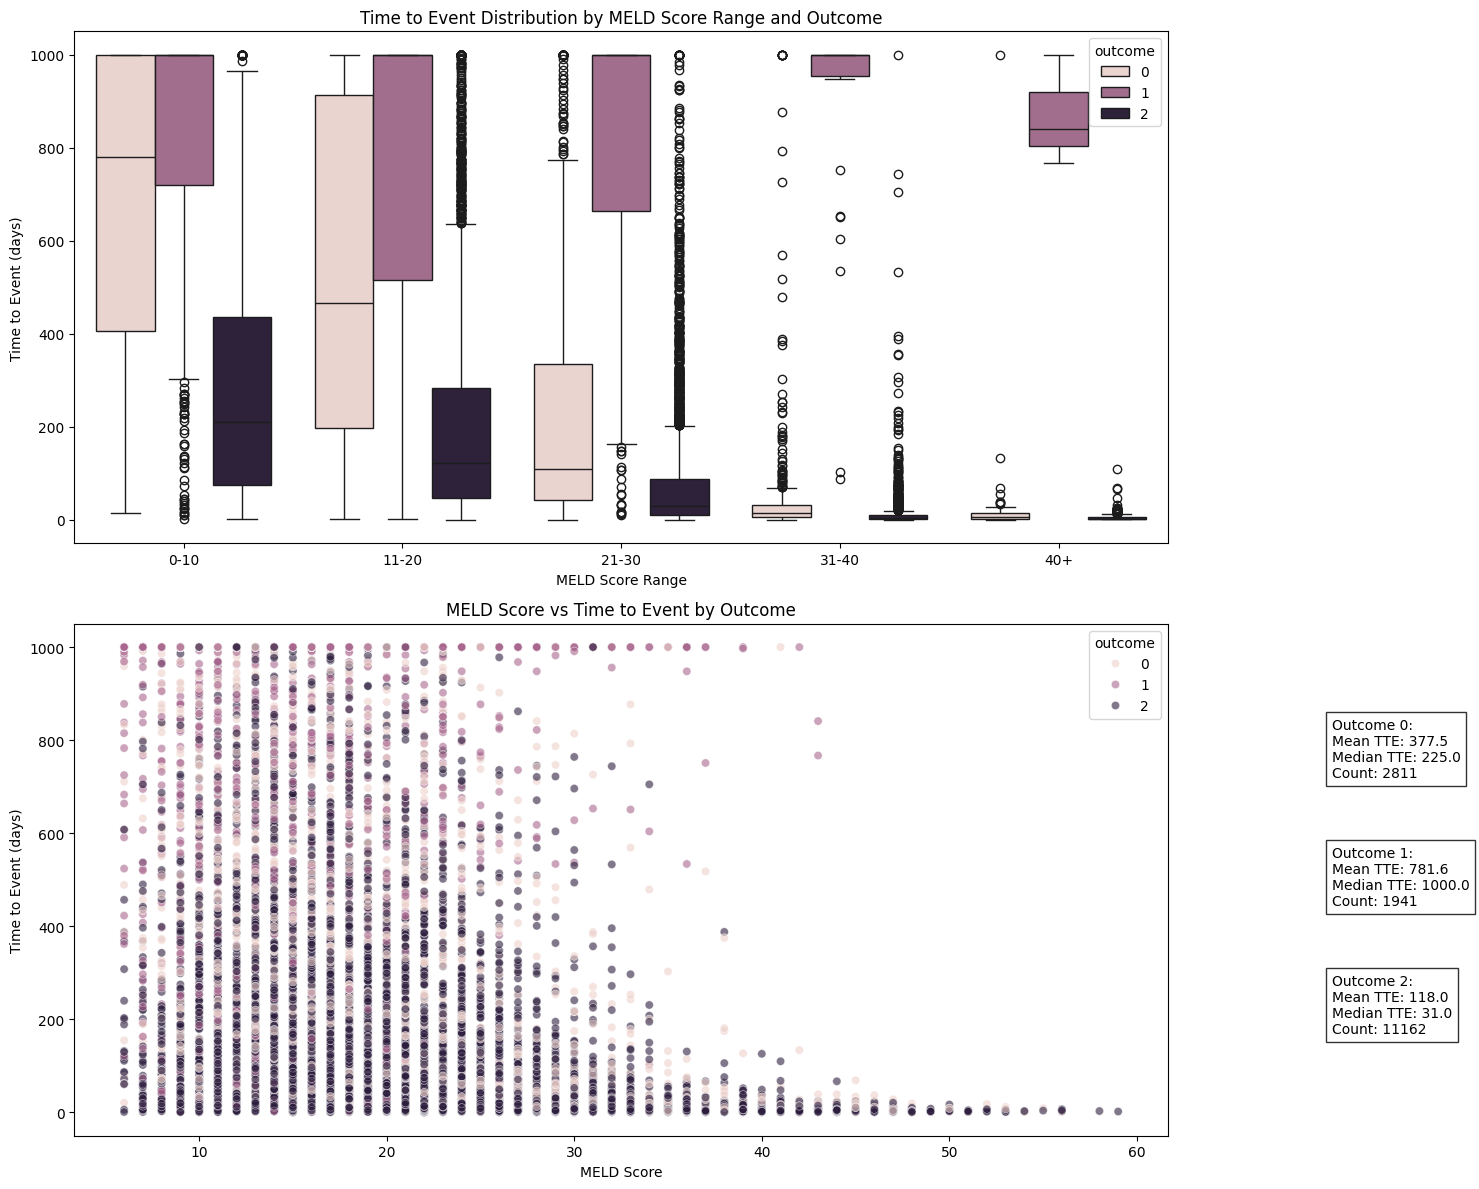


Statistical Summary by MELD Range and Outcome:
                    count    mean  median     std
MELD_range outcome                               
0-10       0          278  681.53   781.0  334.26
           1          498  829.59  1000.0  281.62
           2          462  311.93   211.0  307.88
11-20      0         1201  524.12   466.0  348.34
           1         1113  749.34  1000.0  337.45
           2         3666  217.42   123.0  247.64
21-30      0          853  254.04   110.0  305.96
           1          295  810.40  1000.0  283.81
           2         4025   84.73    30.0  147.48
31-40      0          362   64.15    14.0  172.67
           1           32  883.88  1000.0  246.88
           2         2399   12.96     5.0   40.61
40+        0          117   20.08     7.0   92.72
           1            3  869.33   841.0  119.06
           2          610    5.44     3.0    7.35


<ipython-input-3-50b9f2634fea>:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = real_df.groupby(['MELD_range', 'outcome'])['tte'].agg(['count', 'mean', 'median', 'std']).round(2)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your dataframe is called 'real_df'

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. Boxplot showing tte distribution by MELD score ranges and outcome
# Create MELD score ranges
real_df['MELD_range'] = pd.cut(real_df['MELD'],
                              bins=[0, 10, 20, 30, 40, np.inf],
                              labels=['0-10', '11-20', '21-30', '31-40', '40+'])

# Create boxplot
sns.boxplot(data=real_df, x='MELD_range', y='tte', hue='outcome', ax=axes[0])
axes[0].set_title('Time to Event Distribution by MELD Score Range and Outcome')
axes[0].set_xlabel('MELD Score Range')
axes[0].set_ylabel('Time to Event (days)')

# 2. Scatter plot showing relationship between MELD and tte, colored by outcome
scatter = sns.scatterplot(data=real_df, x='MELD', y='tte',
                         hue='outcome', alpha=0.6, ax=axes[1])
axes[1].set_title('MELD Score vs Time to Event by Outcome')
axes[1].set_xlabel('MELD Score')
axes[1].set_ylabel('Time to Event (days)')

# Add summary statistics as text
for outcome in real_df['outcome'].unique():
    subset = real_df[real_df['outcome'] == outcome]
    stats_text = f'Outcome {outcome}:\n'
    stats_text += f'Mean TTE: {subset["tte"].mean():.1f}\n'
    stats_text += f'Median TTE: {subset["tte"].median():.1f}\n'
    stats_text += f'Count: {len(subset)}'
    axes[1].text(1.15, 0.7 - outcome*0.25, stats_text,
                transform=axes[1].transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional statistical summary
print("\nStatistical Summary by MELD Range and Outcome:")
summary = real_df.groupby(['MELD_range', 'outcome'])['tte'].agg(['count', 'mean', 'median', 'std']).round(2)
print(summary)

In [6]:
# First store the indices of the patients we want to drop
indices_to_drop = filtered_patients.index

# Create new dataframe without these patients
new_df = real_df.drop(indices_to_drop)

# Verify the drop
print(f"Original dataframe size: {len(real_df)}")
print(f"New dataframe size: {len(new_df)}")
print(f"Number of rows dropped: {len(indices_to_drop)}")

# If you want to save this as your new real_df:
real_df = new_df.copy()

# Optional: reset the index if needed
real_df = real_df.reset_index(drop=True)

Original dataframe size: 15914
New dataframe size: 15881
Number of rows dropped: 33


In [7]:
# Filter for patients with:
# 1. MELD > 30
# 2. outcome = 1
# 3. tte > 365

filtered_syn_patients = syn_df[
    (syn_df['MELD'] > 30) &
    (syn_df['outcome'] == 1) &
    (syn_df['tte'] > 365)
]

# Get the count
count = len(filtered_syn_patients)

print(f"Number of patients with MELD > 30, outcome = 1, and TTE > 365: {count}")

# Print summary statistics before dropping
print("\nSummary statistics for this group:")
print(f"Average age: {filtered_syn_patients['Age'].mean():.2f}")
print(f"Average MELD score: {filtered_syn_patients['MELD'].mean():.2f}")
print("\nGender distribution:")
print(filtered_syn_patients['Gender'].value_counts())
print("\nEtiology distribution:")
print(filtered_syn_patients['Etiology'].value_counts())

# Drop these patients from syn_df
indices_to_drop = filtered_syn_patients.index
new_syn_df = syn_df.drop(indices_to_drop)

# Verify the drop
print(f"\nOriginal synthetic dataframe size: {len(syn_df)}")
print(f"New synthetic dataframe size: {len(new_syn_df)}")
print(f"Number of rows dropped: {len(indices_to_drop)}")

# Save as new syn_df
syn_df = new_syn_df.copy()

# Reset index
syn_df = syn_df.reset_index(drop=True)

Number of patients with MELD > 30, outcome = 1, and TTE > 365: 28

Summary statistics for this group:
Average age: 49.31
Average MELD score: 32.32

Gender distribution:
Gender
F    14
M    14
Name: count, dtype: int64

Etiology distribution:
Etiology
Alcohol        17
Biliary         5
Autoimmune      2
NASH            2
Viral           1
Cryptogenic     1
Name: count, dtype: int64

Original synthetic dataframe size: 10000000
New synthetic dataframe size: 9999972
Number of rows dropped: 28


In [10]:
# --- Process synthetic and real data without outcome filtering ---
# Define features
numeric_features = ['Na',
                    'Cr', 'INR', 'Bili',
                    'Albumin']
categorical_features = ['Gender', 'Dialysis', 'outcome']

# Process real data (all outcomes)
real_df = real_df.copy().reset_index(drop=True)
real_df = real_df.drop('MELD_range', axis=1)
print("Real dataset shape:", real_df.shape)

# Process synthetic data (all outcomes)
syn_df_processed = syn_df.copy().reset_index(drop=True)
print("Synthetic dataset shape:", syn_df_processed.shape)

Real dataset shape: (15881, 18)
Synthetic dataset shape: (9999972, 18)


In [16]:
# For real_df
real_df['Ascites_Status'] = real_df['Ascites_Status'].fillna('None')
real_df['Encephalopathy_Status'] = real_df['Encephalopathy_Status'].fillna('None')

# For syn_df
syn_df['Ascites_Status'] = syn_df['Ascites_Status'].fillna('None')
syn_df['Encephalopathy_Status'] = syn_df['Encephalopathy_Status'].fillna('None')

# Verify the changes
print("Real df unique values:")
print("\nAscites_Status categories:", real_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", real_df['Encephalopathy_Status'].unique())

print("\nSynthetic df unique values:")
print("\nAscites_Status categories:", syn_df['Ascites_Status'].unique())
print("Encephalopathy_Status categories:", syn_df['Encephalopathy_Status'].unique())

Real df unique values:

Ascites_Status categories: ['Moderate' 'Slight' 'None' 'Unknown/Not Reported']
Encephalopathy_Status categories: ['Grade 1-2' 'None' 'Grade 3-4' 'Unknown/Not Reported']

Synthetic df unique values:

Ascites_Status categories: ['Slight' 'None' 'Moderate' 'Unknown/Not Reported']
Encephalopathy_Status categories: ['None' 'Grade 1-2' 'Grade 3-4' 'Unknown/Not Reported']


In [17]:
# Get canonical feature names from all synthetic data
syn_categorical_cols = ['Gender', 'Dialysis', 'outcome']

syn_cat_tmp = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded_tmp = pd.get_dummies(syn_cat_tmp, drop_first=False)
cat_feature_names = syn_cat_encoded_tmp.columns
print("Categorical features:", list(cat_feature_names))

Categorical features: ['Gender_F', 'Gender_M', 'Dialysis_A', 'Dialysis_N', 'Dialysis_Y', 'outcome_0', 'outcome_1', 'outcome_2']


In [18]:
# Scale numeric features
scaler = StandardScaler()
syn_numeric = syn_df_processed[numeric_features].astype(float)
scaler = scaler.fit(syn_numeric)

# Process real numeric features
real_numeric = real_df[numeric_features].fillna(real_df[numeric_features].median()).astype(float)
real_numeric_scaled = scaler.transform(real_numeric)

# Process synthetic numeric features
syn_numeric_scaled = scaler.transform(syn_numeric)

In [19]:
# Process real categorical features
real_cat = real_df[categorical_features].copy()

real_cat = real_cat.astype(str)

# One-hot encode
real_cat_encoded = pd.get_dummies(real_cat, drop_first=False)
real_cat_encoded = real_cat_encoded.reindex(columns=cat_feature_names, fill_value=0)

# Process synthetic categorical features
syn_cat = syn_df_processed[syn_categorical_cols].astype(str)
syn_cat_encoded = pd.get_dummies(syn_cat, drop_first=False)

In [20]:
# Combine real features
real_features = np.hstack([real_numeric_scaled, real_cat_encoded.values]).astype(np.float32)
print("Real features shape:", real_features.shape)

# Combine synthetic features
syn_features = np.hstack([syn_numeric_scaled, syn_cat_encoded.values]).astype(np.float32)
print("Synthetic features shape:", syn_features.shape)

Real features shape: (15881, 13)
Synthetic features shape: (9999972, 13)


In [21]:
class PairDataset(Dataset):
    def __init__(self, features, times, outcomes, n_pairs=10000, sim_threshold=30, dissim_threshold=100):
        self.features = np.array(features, dtype=np.float32)
        self.times = np.array(times, dtype=np.float32)
        self.outcomes = np.array(outcomes, dtype=np.float32)
        self.pairs = []
        self.labels = []
        N = self.features.shape[0]
        rng = np.random.RandomState(42)
        count = 0

        while count < n_pairs:
            i = rng.randint(0, N)
            j = rng.randint(0, N)
            if i == j:
                continue

            # Same outcome type (death, transplant, or censoring)
            if self.outcomes[i] == self.outcomes[j]:
                time_diff = abs(self.times[i] - self.times[j])
                if time_diff < sim_threshold:
                    label = 1.0
                elif time_diff > dissim_threshold:
                    label = 0.0
                else:
                    continue
                self.pairs.append((i, j))
                self.labels.append(label)
                count += 1

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        return (torch.tensor(self.features[i], dtype=torch.float32),
                torch.tensor(self.features[j], dtype=torch.float32),
                torch.tensor(self.labels[idx], dtype=torch.float32))

In [23]:
# Create PairDataset and DataLoader for training
pair_dataset = PairDataset(real_features,
                          real_df["tte"].values,
                          real_df["outcome"].values,
                          n_pairs=10000,
                          sim_threshold=30,
                          dissim_threshold=100)
pair_loader = DataLoader(pair_dataset, batch_size=64, shuffle=True)
print("Pair dataset size:", len(pair_dataset))

Pair dataset size: 10000


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class MetricNet(nn.Module):
    def __init__(self, input_dim, embedding_dim=64, hidden_dims=[256, 512, 256, 128]):
        super(MetricNet, self).__init__()

        # Build encoder layers
        layers = []
        current_dim = input_dim

        # Add hidden layers with batch normalization and dropout
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            current_dim = hidden_dim

        # Final embedding layer
        layers.append(nn.Linear(current_dim, embedding_dim))

        self.net = nn.Sequential(*layers)

        # Separate transformation head with batch normalization
        self.transform = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim, bias=False),
            nn.BatchNorm1d(embedding_dim)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        emb = self.net(x)
        transformed = self.transform(emb)
        normalized = F.normalize(transformed, p=2, dim=1)
        return normalized

In [25]:
# Initialize model
input_dim = real_features.shape[1]
model_metric = MetricNet(input_dim, embedding_dim=64).to(device)

# Use different learning rates for different parts
params_dict = [
    {'params': model_metric.net.parameters(), 'lr': 1e-3},
    {'params': model_metric.transform.parameters(), 'lr': 5e-4}
]
optimizer_metric = torch.optim.AdamW(params_dict, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_metric, mode='min', factor=0.5, patience=10, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [26]:
# Define contrastive loss function
def contrastive_loss(x1, x2, label, margin=1.0):
    """
    Contrastive loss function
    x1, x2: embeddings of pairs
    label: 1 if similar, 0 if dissimilar
    margin: minimum distance for dissimilar pairs
    """
    # Compute Euclidean distance between x1 and x2
    d = torch.norm(x1 - x2, p=2, dim=1)
    # Loss for similar pairs (label=1): want small distance
    loss_sim = label * d**2
    # Loss for dissimilar pairs (label=0): want distance > margin
    loss_dissim = (1 - label) * torch.clamp(margin - d, min=0.0)**2
    # Return mean loss
    loss = torch.mean(loss_sim + loss_dissim)
    return loss

In [27]:
num_epochs_metric = 200
best_loss = float('inf')
patience_counter = 0
early_stop_patience = 20

for epoch in range(num_epochs_metric):
    model_metric.train()
    total_loss = 0.0
    batch_losses = []

    for x1, x2, label in pair_loader:
        x1 = x1.to(device)
        x2 = x2.to(device)
        label = label.to(device)

        emb1 = model_metric(x1)
        emb2 = model_metric(x2)
        loss = contrastive_loss(emb1, emb2, label, margin=1.0)

        optimizer_metric.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_metric.parameters(), max_norm=1.0)

        optimizer_metric.step()
        total_loss += loss.item() * x1.size(0)
        batch_losses.append(loss.item())

    avg_loss = total_loss / len(pair_dataset)
    print(f"Epoch {epoch+1}/{num_epochs_metric}, Loss: {avg_loss:.4f}")

    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print("Early stopping triggered")
        break

Epoch 1/200, Loss: 0.4129
Epoch 2/200, Loss: 0.2027
Epoch 3/200, Loss: 0.1934
Epoch 4/200, Loss: 0.1896
Epoch 5/200, Loss: 0.1883
Epoch 6/200, Loss: 0.1863
Epoch 7/200, Loss: 0.1922
Epoch 8/200, Loss: 0.1820
Epoch 9/200, Loss: 0.1845
Epoch 10/200, Loss: 0.1810
Epoch 11/200, Loss: 0.1826
Epoch 12/200, Loss: 0.1816
Epoch 13/200, Loss: 0.1844
Epoch 14/200, Loss: 0.1803
Epoch 15/200, Loss: 0.1774
Epoch 16/200, Loss: 0.1784
Epoch 17/200, Loss: 0.1780
Epoch 18/200, Loss: 0.1761
Epoch 19/200, Loss: 0.1771
Epoch 20/200, Loss: 0.1756
Epoch 21/200, Loss: 0.1763
Epoch 22/200, Loss: 0.1760
Epoch 23/200, Loss: 0.1772
Epoch 24/200, Loss: 0.1771
Epoch 25/200, Loss: 0.1811
Epoch 26/200, Loss: 0.1748
Epoch 27/200, Loss: 0.1745
Epoch 28/200, Loss: 0.1750
Epoch 29/200, Loss: 0.1730
Epoch 30/200, Loss: 0.1776
Epoch 31/200, Loss: 0.1723
Epoch 32/200, Loss: 0.1738
Epoch 33/200, Loss: 0.1735
Epoch 34/200, Loss: 0.1737
Epoch 35/200, Loss: 0.1707
Epoch 36/200, Loss: 0.1733
Epoch 37/200, Loss: 0.1722
Epoch 38/2

In [28]:
# Compute embeddings in batches
def compute_embeddings_in_batches(model, features, batch_size=1000, device='cuda'):
    model.eval()
    embeddings = []

    with torch.no_grad():
        # Process data in batches
        for i in range(0, len(features), batch_size):
            batch = torch.tensor(
                features[i:i + batch_size],
                dtype=torch.float32,
                device=device
            )
            batch_embeddings = model(batch).cpu().numpy()
            embeddings.append(batch_embeddings)

            if i % 10000 == 0:
                print(f"Processed {i}/{len(features)} samples")

    # Concatenate all batches
    return np.vstack(embeddings)

# Compute synthetic embeddings in batches
print("Computing synthetic embeddings...")
syn_embeddings = compute_embeddings_in_batches(
    model_metric,
    syn_features,
    batch_size=1000,
    device=device
)
print("Synthetic embeddings shape:", syn_embeddings.shape)

# Compute real embeddings (smaller dataset, can process at once)
print("\nComputing real embeddings...")
with torch.no_grad():
    real_features_tensor = torch.tensor(real_features, dtype=torch.float32, device=device)
    real_embeddings = model_metric(real_features_tensor).cpu().numpy()
print("Real embeddings shape:", real_embeddings.shape)

Computing synthetic embeddings...
Processed 0/9999972 samples
Processed 10000/9999972 samples
Processed 20000/9999972 samples
Processed 30000/9999972 samples
Processed 40000/9999972 samples
Processed 50000/9999972 samples
Processed 60000/9999972 samples
Processed 70000/9999972 samples
Processed 80000/9999972 samples
Processed 90000/9999972 samples
Processed 100000/9999972 samples
Processed 110000/9999972 samples
Processed 120000/9999972 samples
Processed 130000/9999972 samples
Processed 140000/9999972 samples
Processed 150000/9999972 samples
Processed 160000/9999972 samples
Processed 170000/9999972 samples
Processed 180000/9999972 samples
Processed 190000/9999972 samples
Processed 200000/9999972 samples
Processed 210000/9999972 samples
Processed 220000/9999972 samples
Processed 230000/9999972 samples
Processed 240000/9999972 samples
Processed 250000/9999972 samples
Processed 260000/9999972 samples
Processed 270000/9999972 samples
Processed 280000/9999972 samples
Processed 290000/999997

In [31]:
syn_df.columns

Index(['Age', 'BMI', 'Na', 'Cr', 'INR', 'Bili', 'Albumin', 'MELD', 'tte',
       'Gender', 'ABO', 'Dialysis', 'Etiology', 'Ethnicity',
       'diab_group_labeled', 'Encephalopathy_Status', 'Ascites_Status',
       'outcome'],
      dtype='object')

In [35]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare the synthetic data: treat only outcome 0 (death) as event; transplant (2) and censored (1) are censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['death_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x == 0 else 0)
syn_df_processed['death_tte'] = syn_df_processed['tte']  # Use the same TTE column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays of length n.
    This simple implementation sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    # Sort times and events by times.
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    # Loop over each unique time.
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    # If survival never drops below 0.5, fallback to max observed time.
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median death TTE using the fast method.
def compute_local_median_death_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'death_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'death_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median for each real patient using joblib with the threading backend and a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing local medians", total=n_real)) as progress_bar:
    predicted_death_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_fast)(i) for i in range(n_real)
    )
predicted_death_medians = np.array(predicted_death_medians)

# 6. Add the predicted death-based TTE to your real_df.
real_df['predicted_death_tte'] = predicted_death_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_death_tte']].head())


/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Computing local medians:   0%|          | 0/15881 [00:00<?, ?it/s]

  0%|          | 0/15881 [00:00<?, ?it/s]

   predicted_death_tte
0           524.453554
1           315.727344
2          1000.000000
3           167.283664
4          1000.000000


In [38]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_embeddings: synthetic embeddings (shape: [n_syn, embed_dim])
# - real_embeddings: real embeddings (shape: [n_real, embed_dim])
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - real_df: real patients DataFrame.

# 1. Prepare synthetic data:
#    Define composite_event = 1 for death (0) and transplant (2); outcome 1 is censored.
syn_df_processed = syn_df_processed.copy()
syn_df_processed['composite_event'] = syn_df_processed['outcome'].apply(lambda x: 1 if x in [0, 2] else 0)
syn_df_processed['composite_tte'] = syn_df_processed['tte']  # Use the same time-to-event column

# 2. Set up nearest neighbor search using synthetic embeddings.
n_neighbors = 100
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(syn_embeddings)
# Retrieve neighbor indices for all real patients (shape: [n_real, n_neighbors])
distances_all, indices_all = nbrs.kneighbors(real_embeddings)

# 3. Define a fast custom function to compute the Kaplan–Meier median from a small sample.
def fast_km_median(times, events):
    """
    Compute a Kaplan-Meier median survival time from a small sample.
    Assumes times and events are 1D NumPy arrays.
    The function sorts the times, computes the survival function,
    and returns the first time when survival falls below 0.5.
    """
    order = np.argsort(times)
    times = times[order]
    events = events[order]

    n = len(times)
    survival = 1.0
    median_time = None
    at_risk = n
    for t, e in zip(times, events):
        if at_risk > 0:
            survival *= (1 - e / at_risk)
        if survival <= 0.5:
            median_time = t
            break
        at_risk -= 1
    if median_time is None:
        median_time = times[-1]
    return median_time

# 4. Define a function to compute the local median composite TTE using the fast method.
def compute_local_median_composite_fast(idx):
    neighbor_idxs = indices_all[idx]
    neighbor_tte = syn_df_processed.loc[neighbor_idxs, 'composite_tte'].values
    neighbor_event = syn_df_processed.loc[neighbor_idxs, 'composite_event'].values
    return fast_km_median(neighbor_tte, neighbor_event)

# 5. Compute the local median composite TTE for each real patient using joblib (threading backend) with a progress bar.
n_real = real_embeddings.shape[0]
with tqdm_joblib(tqdm(desc="Computing composite medians", total=n_real)) as progress_bar:
    predicted_composite_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_composite_fast)(i) for i in range(n_real)
    )
predicted_composite_medians = np.array(predicted_composite_medians)

# 6. Add the predicted composite TTE to your real_df.
real_df['predicted_composite_tte'] = predicted_composite_medians

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())



Computing composite medians:   0%|          | 0/15881 [00:00<?, ?it/s]

  0%|          | 0/15881 [00:00<?, ?it/s]

   predicted_composite_tte
0               524.453554
1                11.000000
2              1000.000000
3               167.283664
4               106.110790


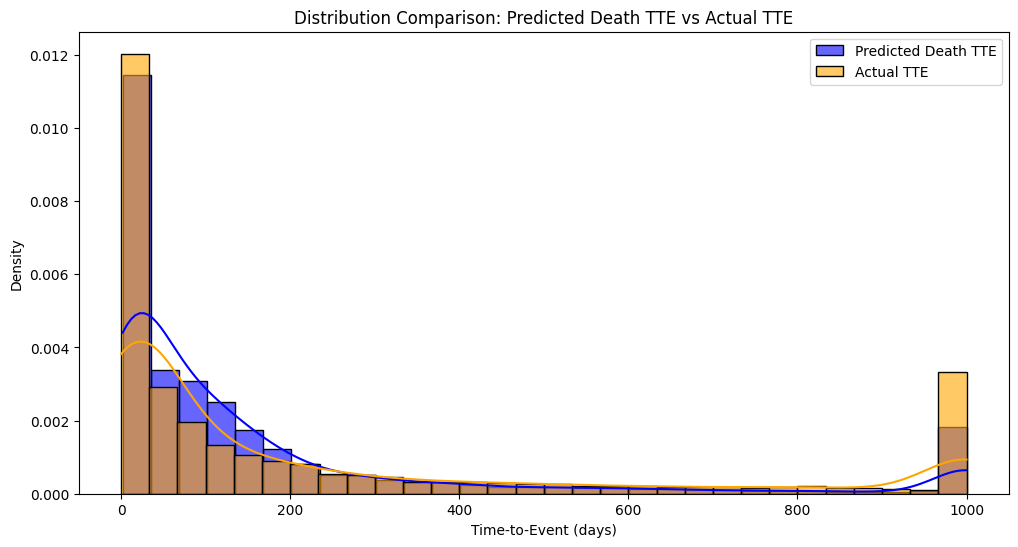

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
# Plot the predicted death-based TTE distribution.
sns.histplot(real_df['predicted_composite_tte'], bins=30, color='blue', label='Predicted Death TTE', stat='density', kde=True, alpha=0.6)
# Plot the actual TTE distribution.
sns.histplot(real_df['tte'], bins=30, color='orange', label='Actual TTE', stat='density', kde=True, alpha=0.6)

plt.xlabel('Time-to-Event (days)')
plt.ylabel('Density')
plt.title('Distribution Comparison: Predicted Death TTE vs Actual TTE')
plt.legend()
plt.show()


Pearson correlation: 0.620 (p-value: 0)
Spearman correlation: 0.766 (p-value: 0)


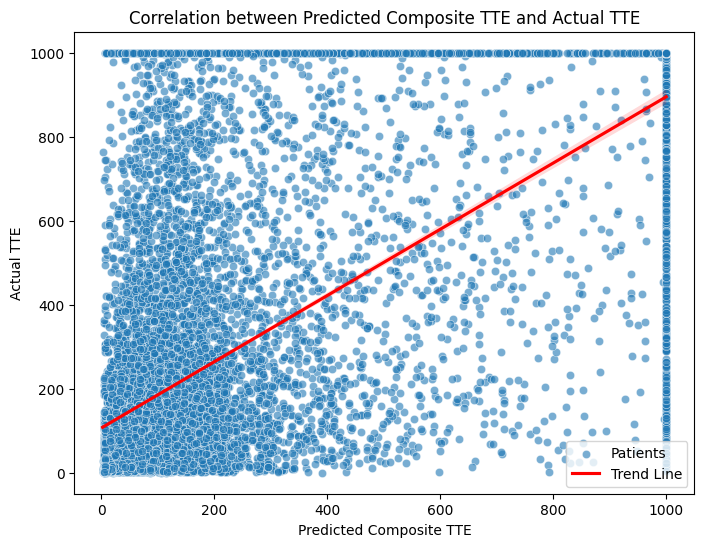

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Compute correlation coefficients
pearson_corr, pearson_p = pearsonr(real_df['predicted_composite_tte'], real_df['tte'])
spearman_corr, spearman_p = spearmanr(real_df['predicted_composite_tte'], real_df['tte'])

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3g})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3g})")

# Create a scatter plot with a regression line
plt.figure(figsize=(8,6))
sns.scatterplot(x=real_df['predicted_composite_tte'], y=real_df['tte'], alpha=0.6, label='Patients')
sns.regplot(x=real_df['predicted_composite_tte'], y=real_df['tte'], scatter=False, color='red', label='Trend Line')
plt.xlabel('Predicted Composite TTE')
plt.ylabel('Actual TTE')
plt.title('Correlation between Predicted Composite TTE and Actual TTE')
plt.legend()
plt.show()


In [41]:
def calculate_meld3(row):
    # Determine if female (1 if F, 0 otherwise)
    female = 1 if row['Gender'] == 'F' else 0

    # Apply lower/upper bounds as needed
    bilirubin = max(1.0, row['Bili'])
    sodium = min(137, max(125, row['Na']))
    inr = max(1.0, row['INR'])

    # Set creatinine based on dialysis status
    if row['Dialysis'] == 'Y':
        creatinine = 3.0
    else:
        creatinine = min(3.0, max(1.0, row['Cr']))

    albumin = min(3.5, max(1.5, row['Albumin']))

    # Calculate components
    female_component = 1.33 * female
    bilirubin_component = 4.56 * np.log(bilirubin)
    sodium_component = 0.82 * (137 - sodium)
    interaction1 = -0.24 * (137 - sodium) * np.log(bilirubin)
    inr_component = 9.09 * np.log(inr)
    creatinine_component = 11.14 * np.log(creatinine)
    albumin_component = 1.85 * (3.5 - albumin)
    interaction2 = -1.83 * (3.5 - albumin) * np.log(creatinine)
    constant = 6

    # Sum all components to get the MELD3 score and round it
    meld3 = (female_component + bilirubin_component + sodium_component +
             interaction1 + inr_component + creatinine_component +
             albumin_component + interaction2 + constant)
    return round(meld3)

# Apply the function to add a new column 'meld3' to real_df
real_df['meld3'] = real_df.apply(calculate_meld3, axis=1)



In [42]:
real_df.head()

,Age,BMI,Na,Cr,INR,Bili,Albumin,MELD,tte,Gender,...,Dialysis,Etiology,Ethnicity,diab_group_labeled,Encephalopathy_Status,Ascites_Status,outcome,predicted_death_tte,predicted_composite_tte,meld3
0,59.0,29.629630,142.0,0.50,1.5,4.30,3.8,16.0,1000.0,F,...,N,Viral,Hispanic/Latino,No Diabetes,Grade 1-2,Moderate,1,524.453554,524.453554,18
1,68.0,28.289299,127.0,1.41,1.7,11.40,2.5,30.0,7.0,M,...,N,Other,White,No Diabetes,Grade 1-2,Slight,2,315.727344,11.000000,29
2,68.0,30.379642,139.0,0.85,1.2,1.80,3.5,11.0,684.0,M,...,N,Other,White,No Diabetes,Grade 1-2,Slight,0,1000.000000,1000.000000,10
3,60.0,23.618282,133.0,1.35,1.6,2.30,2.8,21.0,207.0,F,...,N,NASH,White,Diabetes,Grade 1-2,Slight,0,167.283664,167.283664,22
4,64.0,26.393870,131.0,1.51,1.2,1.09,4.2,18.0,14.0,M,...,N,Cryptogenic,Hispanic/Latino,No Diabetes,None,Moderate,2,1000.000000,106.110790,17


In [43]:
from sklearn.metrics import auc
from lifelines import CoxPHFitter
from scipy import stats
from sklearn.metrics import roc_auc_score


def calculate_cumulative_incidence(times, events, predict_time):
    """Calculate cumulative incidence at specified time"""
    n_total = len(times)
    n_events = sum((events == 1) & (times <= predict_time))
    return n_events / n_total

def bootstrap_ci(metric_func, data, n_bootstrap=1000, alpha=0.05):
    """Calculate confidence intervals using bootstrapping"""
    bootstrap_estimates = []
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, len(data), len(data))
        bootstrap_sample = data.iloc[indices]
        estimate = metric_func(bootstrap_sample)
        bootstrap_estimates.append(estimate)

    ci_lower = np.percentile(bootstrap_estimates, alpha/2 * 100)
    ci_upper = np.percentile(bootstrap_estimates, (1-alpha/2) * 100)
    return ci_lower, ci_upper

In [44]:
from sklearn.metrics import roc_auc_score

# Define time points for evaluation
time_points = [7, 14, 30, 90, 180, 360]
results = []

for t in time_points:
    # Create a mask to exclude transplants (assume outcome 2 is transplant)
    mask = real_df['outcome'].isin([0, 1])
    df_filtered = real_df[mask]

    # Create death indicator (1 if death occurred by time t, 0 if still waiting)
    death_indicator = ((df_filtered['outcome'] == 0) &
                       (df_filtered['tte'] <= t)).astype(int)

    # Define risk scores (the lower the predicted median time, the higher the risk)
    risk_scores = -df_filtered['predicted_composite_tte']

    # Calculate AUC for death prediction using the filtered dataset
    death_auc = roc_auc_score(death_indicator, risk_scores)

    # Calculate cumulative incidence on the full dataset (if desired) or on df_filtered
    n_death = death_indicator.sum()
    # For cumulative incidence, you might want to consider only those in df_filtered as well:
    n_total = len(df_filtered)
    death_ci = n_death / n_total

    results.append({
        'Time': t,
        'N_death': n_death,
        'N_total': n_total,
        'Death_rate': death_ci,
        'AUC': death_auc
    })

results_df = pd.DataFrame(results)
print("\nResults at different time points (excluding transplants):")
print(results_df)



Results at different time points (excluding transplants):
   Time  N_death  N_total  Death_rate       AUC
0     7      210     4719    0.044501  0.946241
1    14      354     4719    0.075016  0.945218
2    30      575     4719    0.121848  0.937133
3    90      963     4719    0.204069  0.887389
4   180     1267     4719    0.268489  0.843642
5   360     1658     4719    0.351346  0.798729


In [45]:

from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Exclude transplants (outcome_encoded == 2)
df_filtered = real_df[real_df['outcome'].isin([0, 1])].copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - died on/before time t
    at_risk_mask = (
        (df_filtered['tte'] >= t) |
        ((df_filtered['outcome'] == 0) & (df_filtered['tte'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_filtered[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'] == 0) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    #    so we use the negative of that column.
    risk_metric = -df_at_risk['predicted_composite_tte']

    #    For meld3, typically a higher meld3 => higher risk,
    #    so we can use it as is. (Adjust if your convention is reversed.)
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        # If we have all events or no events in this subset, AUC is not defined
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nNaive Time-Dependent AUC (Excluding Transplants):")
print(results_df)


Naive Time-Dependent AUC (Excluding Transplants):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7       4715            210    0.946204   0.954837
1    14       4707            354    0.945143   0.954294
2    30       4681            575    0.937018   0.947288
3    90       4614            963    0.887376   0.908194
4   180       4529           1267    0.843928   0.872993
5   360       4422           1658    0.799552   0.836582


In [46]:
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients (both events and censored)
df_all = real_df.copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - had an event (death or transplant) on/before time t
    at_risk_mask = (
        (df_all['tte'] >= t) |
        ((df_all['outcome'].isin([0, 2])) & (df_all['tte'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    risk_metric = -df_at_risk['predicted_composite_tte']
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nTime-Dependent AUC (Composite Outcome - Death or Transplant):")
print(results_df)


Time-Dependent AUC (Composite Outcome - Death or Transplant):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7      15877           3194    0.885645   0.884009
1    14      15869           4571    0.893919   0.885309
2    30      15843           6139    0.901347   0.882665
3    90      15776           8609    0.892402   0.858389
4   180      15691          10245    0.886765   0.841877
5   360      15584          11770    0.888852   0.829922


In [47]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.788          0.909             0.913
1    14           0.791          0.909             0.913
2    30           0.778          0.900             0.906
3    90           0.717          0.865             0.875
4   180           0.679          0.838             0.852
5   360           0.652          0.815             0.830

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      1.000     1.201     0.786      0.0
1    14      1.001     1.216     0.263      0.0
2    30      1.001     1.229     0.003      0.0
3    90      1.001     1.226     0.000      0.0
4   180      1.001     1.219     0.000      0.0
5   360      1.001     1.207     0.000      0.0


In [49]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - indices_all: a NumPy array of shape [n_real, n_neighbors] with neighbor indices already computed.
# - real_df: real patients DataFrame.

def compute_local_median_event(idx):
    # Get the precomputed neighbor indices for the real patient.
    neighbor_idxs = indices_all[idx]
    # Retrieve the neighbors' data from the synthetic DataFrame.
    neighbors = syn_df_processed.loc[neighbor_idxs]
    # Filter neighbors to include only those with an event (death=0 or transplant=2).
    event_neighbors = neighbors[neighbors['outcome'].isin([0, 2])]

    # If there is at least one neighbor with an event, use the median TTE.
    if len(event_neighbors) > 0:
        return np.median(event_neighbors['tte'].values)
    else:
        # Fallback: if no neighbor had an event, use the median TTE from all neighbors.
        return np.median(neighbors['tte'].values)

# Number of real patients (n_real) is inferred from the shape of real embeddings.
n_real = indices_all.shape[0]

# Compute the local median event-based TTE for each real patient using joblib with a progress bar.
with tqdm_joblib(tqdm(desc="Computing median event TTE", total=n_real)) as progress_bar:
    predicted_event_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_event)(i) for i in range(n_real)
    )
predicted_event_medians = np.array(predicted_event_medians)

# Add the predicted TTE (based on events) to your real_df.
real_df['predicted_event_tte'] = predicted_event_medians

# Optional: Display a sample of the predictions.
print(real_df[['predicted_event_tte']].head())




Computing median event TTE:   0%|          | 0/15881 [00:00<?, ?it/s]

  0%|          | 0/15881 [00:00<?, ?it/s]

Computing composite medians:   0%|          | 0/15881 [17:23<?, ?it/s]


   predicted_event_tte
0           474.048243
1            11.000000
2          1000.000000
3           178.147590
4           111.055395


In [51]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# --- Assumptions ---
# - syn_df_processed: synthetic DataFrame with columns 'tte' and 'outcome'
#    where outcome: 0 = death, 1 = censored, 2 = transplant.
# - indices_all: a NumPy array of shape [n_real, n_neighbors] with neighbor indices already computed.
# - real_df: real patients DataFrame.

def compute_local_median_death_only(idx):
    # Get the precomputed neighbor indices for the real patient.
    neighbor_idxs = indices_all[idx]
    # Retrieve the neighbors' data from the synthetic DataFrame.
    neighbors = syn_df_processed.loc[neighbor_idxs]
    # Filter neighbors to include only those with death as the outcome.
    death_neighbors = neighbors[neighbors['outcome'] == 0]

    # If there is at least one neighbor with a death event, use the median TTE.
    if len(death_neighbors) > 0:
        return np.median(death_neighbors['tte'].values)
    else:
        # Fallback: if no neighbor had a death event, use the median TTE from all neighbors.
        return np.median(neighbors['tte'].values)

# Number of real patients is inferred from the shape of indices_all.
n_real = indices_all.shape[0]

# Compute the local median death-only TTE for each real patient using joblib with a progress bar.
with tqdm_joblib(tqdm(desc="Computing death-only median TTE", total=n_real)) as progress_bar:
    predicted_death_only_medians = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_local_median_death_only)(i) for i in range(n_real)
    )
predicted_death_only_medians = np.array(predicted_death_only_medians)

# Add the predicted TTE (based on death events only) to your real_df.
real_df['predicted_death_only_tte'] = predicted_death_only_medians

# Optional: Display a sample of the predictions.
print(real_df[['predicted_death_only_tte']].head())


Computing death-only median TTE:   0%|          | 0/15881 [00:00<?, ?it/s]

  0%|          | 0/15881 [00:00<?, ?it/s]

   predicted_death_only_tte
0                474.048243
1                 11.000000
2               1000.000000
3                178.147590
4                111.055395


In [50]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_event_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_event_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_event_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_event_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.784          0.909             0.915
1    14           0.785          0.909             0.916
2    30           0.769          0.900             0.912
3    90           0.696          0.865             0.890
4   180           0.649          0.838             0.875
5   360           0.611          0.815             0.861

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      1.001     1.207     0.204      0.0
1    14      1.002     1.223     0.004      0.0
2    30      1.002     1.239     0.000      0.0
3    90      1.003     1.244     0.000      0.0
4   180      1.003     1.243     0.000      0.0
5   360      1.003     1.239     0.000      0.0


In [52]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_only_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_only_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_only_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_only_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.782          0.909             0.915
1    14           0.784          0.909             0.916
2    30           0.768          0.900             0.911
3    90           0.696          0.865             0.890
4   180           0.649          0.838             0.874
5   360           0.611          0.815             0.861

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      1.001     1.207     0.187      0.0
1    14      1.002     1.223     0.005      0.0
2    30      1.002     1.239     0.000      0.0
3    90      1.003     1.243     0.000      0.0
4   180      1.003     1.242     0.000      0.0
5   360      1.003     1.238     0.000      0.0


In [58]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd
from tqdm.notebook import tqdm

def prepare_data(df, t=90):
    """
    Prepare data for 90-day death analysis
    """
    analysis_df = df.copy()

    # Create death event indicator (1 for death, 0 for censoring/transplant)
    analysis_df['event'] = (analysis_df['outcome'] == 0).astype(int)

    # Apply 90-day cutoff
    mask = analysis_df['tte'] > t
    analysis_df.loc[mask, 'tte'] = t
    analysis_df.loc[mask, 'event'] = 0

    return analysis_df

def get_model_predictions(df, model_type='meld3'):
    """Get predictions from fitted Cox model"""
    if model_type == 'meld3':
        cph = CoxPHFitter()
        data = df[['tte', 'event', 'meld3']].copy()
        cph.fit(data, duration_col='tte', event_col='event', show_progress=False)
        return -df['meld3']  # Negative because higher MELD3 means higher risk
    else:  # combined
        cph = CoxPHFitter()
        data = df[['tte', 'event', 'predicted_death_only_tte', 'meld3']].copy()
        cph.fit(data, duration_col='tte', event_col='event', show_progress=False)
        return -(df['predicted_death_only_tte'] * cph.params_['predicted_death_only_tte'] +
                df['meld3'] * cph.params_['meld3'])

def bootstrap_comparison(df, n_bootstrap=500):
    """Perform bootstrap comparison of MELD3 vs combined model"""
    n_samples = len(df)
    diffs = np.zeros(n_bootstrap)

    # Get baseline concordance indices
    print("\nCalculating baseline concordance indices...")
    meld3_pred = get_model_predictions(df, 'meld3')
    combined_pred = get_model_predictions(df, 'combined')

    baseline_meld3 = concordance_index(
        df['tte'],
        meld3_pred,
        df['event']
    )
    baseline_combined = concordance_index(
        df['tte'],
        combined_pred,
        df['event']
    )

    print("\nRunning bootstrap iterations...")
    for i in tqdm(range(n_bootstrap), desc='Bootstrap Progress'):
        # Generate bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_df = df.iloc[indices].copy()

        # Get predictions for bootstrap sample
        meld3_pred = get_model_predictions(boot_df, 'meld3')
        combined_pred = get_model_predictions(boot_df, 'combined')

        # Calculate c-indices
        meld3_cindex = concordance_index(
            boot_df['tte'],
            meld3_pred,
            boot_df['event']
        )
        combined_cindex = concordance_index(
            boot_df['tte'],
            combined_pred,
            boot_df['event']
        )

        diffs[i] = combined_cindex - meld3_cindex

    return {
        'baseline': (baseline_meld3, baseline_combined),
        'diffs': diffs
    }

# Prepare data
print("Preparing data...")
analysis_df = prepare_data(real_df, t=90)

# Print event counts
print("\nCounts at 90 days:")
print(f"Deaths: {sum(analysis_df['event'] == 1)}")
print(f"Censored (includes transplants and alive): {sum(analysis_df['event'] == 0)}")
print(f"Total: {len(analysis_df)}")

# Run bootstrap
results = bootstrap_comparison(analysis_df)

# Print results
print("\nBaseline C-indices:")
print(f"MELD3: {results['baseline'][0]:.3f}")
print(f"Combined: {results['baseline'][1]:.3f}")
print(f"Observed difference: {results['baseline'][1] - results['baseline'][0]:.3f}")

# Calculate confidence intervals and p-values
ci = np.percentile(results['diffs'], [2.5, 97.5])
p_value = 2 * min(np.mean(results['diffs'] <= 0),
                  np.mean(results['diffs'] >= 0))

print("\nBootstrap Results:")
print(f"Mean difference in c-index: {np.mean(results['diffs']):.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")
print(f"P-value: {p_value:.4f}")

# Create histogram of differences
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(results['diffs'], bins=50, density=True, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label='Null hypothesis (no difference)')
plt.axvline(x=np.mean(results['diffs']), color='g', linestyle='-',
            label=f'Mean difference: {np.mean(results["diffs"]):.3f}')
plt.xlabel('Difference in C-index (Combined - MELD3)')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Difference in C-indices')
plt.legend()
plt.savefig('bootstrap_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

Preparing data...

Counts at 90 days:
Deaths: 963
Censored (includes transplants and alive): 14918
Total: 15881

Calculating baseline concordance indices...

Running bootstrap iterations...


Bootstrap Progress:   0%|          | 0/500 [00:00<?, ?it/s]


Baseline C-indices:
MELD3: 0.865
Combined: 0.890
Observed difference: 0.025

Bootstrap Results:
Mean difference in c-index: 0.025
95% CI: [0.020, 0.030]
P-value: 0.0000


In [90]:
import pandas as pd
from lifelines import CoxPHFitter

# Ensure analysis_df has been prepared, which should include the 'event' column.
analysis_df = prepare_data(real_df, t=90)

# Now prepare the data with the necessary columns.
data = analysis_df[['tte', 'event', 'meld3', 'predicted_death_only_tte']].copy()

# Fit the Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(data, duration_col='tte', event_col='event', show_progress=False)

# Extract and print the coefficients, hazard ratios, and p-values for 'meld3' and 'predicted_death_only_tte'
hazard_ratios = cph.summary.loc[['meld3', 'predicted_death_only_tte'], ['coef', 'exp(coef)', 'p']]
print("Hazard Ratios and p-values for MELD3 and predicted TTE:")
print(hazard_ratios)


Hazard Ratios and p-values for MELD3 and predicted TTE:
                              coef  exp(coef)             p
covariate                                                  
meld3                     0.217339   1.242766  0.000000e+00
predicted_death_only_tte  0.002681   1.002684  9.013979e-45


Counts by Predicted TTE Category:
predicted_tte_category
<30 days        5642
30-90 days      3478
90-180 days     3420
180-360 days    1753
360+ days       1588
Name: count, dtype: int64


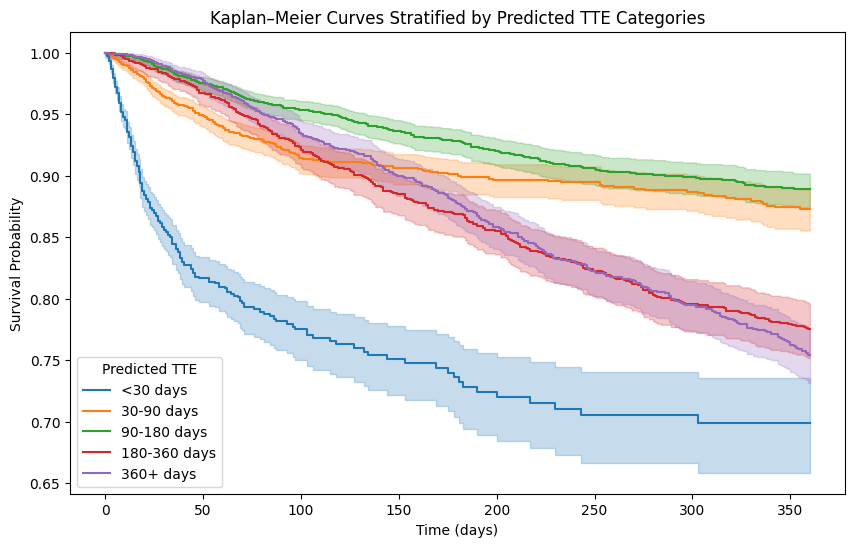

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Define bins and labels for predicted_death_only_tte
bins = [0, 30, 90, 180, 360, np.inf]
labels = ['<30 days', '30-90 days', '90-180 days', '180-360 days', '360+ days']

# Create a new column for the predicted TTE category
real_df['predicted_tte_category'] = pd.cut(real_df['predicted_death_only_tte'],
                                            bins=bins,
                                            labels=labels,
                                            right=False)

# Display the counts in each category
print("Counts by Predicted TTE Category:")
print(real_df['predicted_tte_category'].value_counts().sort_index())

# Prepare survival data for Kaplan-Meier analysis (using, e.g., a 360-day cutoff)
def prepare_data(df, t=360):
    analysis_df = df.copy()
    analysis_df['event'] = (analysis_df['outcome'] == 0).astype(int)
    mask = analysis_df['tte'] > t
    analysis_df.loc[mask, 'tte'] = t
    analysis_df.loc[mask, 'event'] = 0
    return analysis_df

analysis_df = prepare_data(real_df, t=360)

# Plot Kaplan-Meier curves stratified by predicted TTE category
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for cat in labels:
    mask = analysis_df['predicted_tte_category'] == cat
    if mask.sum() > 0:
        kmf.fit(analysis_df.loc[mask, 'tte'], event_observed=analysis_df.loc[mask, 'event'], label=cat)
        kmf.plot(ci_show=True)
plt.title("Kaplan–Meier Curves Stratified by Predicted TTE Categories")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend(title="Predicted TTE")
plt.show()


In [93]:
import pandas as pd
from lifelines import CoxPHFitter

# We'll assume you already have a DataFrame called analysis_df that includes:
#   'tte'    : time to event (with any cutoff applied if desired)
#   'event'  : 1 if death, 0 if censored/transplant
#   'predicted_death_only_tte': your predicted TTE

def fit_univariate_cox(df):
    # Extract just the columns needed for univariate analysis
    data = df[['tte', 'event', 'predicted_death_only_tte']].copy()

    # Fit the Cox model with only predicted_death_only_tte as the predictor
    cph = CoxPHFitter()
    cph.fit(data, duration_col='tte', event_col='event', show_progress=False)

    # Print the model summary, which includes coefficient, hazard ratio, and p-value
    print("Univariate Cox model using predicted_death_only_tte:")
    print(cph.summary)

# Example usage (assuming analysis_df is your DataFrame):
fit_univariate_cox(analysis_df)


Univariate Cox model using predicted_death_only_tte:
                             coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                
predicted_death_only_tte -0.00025    0.99975  0.000105       -0.000456   

                          coef upper 95%  exp(coef) lower 95%  \
covariate                                                       
predicted_death_only_tte       -0.000043             0.999544   

                          exp(coef) upper 95%  cmp to         z         p  \
covariate                                                                   
predicted_death_only_tte             0.999957     0.0 -2.372622  0.017662   

                          -log2(p)  
covariate                           
predicted_death_only_tte  5.823182  


In [94]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 10       # Number of closest neighbors who died
ALPHA = 1e-6     # Small constant to avoid division by zero in weights

def compute_weighted_death_tte(idx):
    """
    Compute a weighted average TTE based on the top K neighbors who died.
    Weights are set as 1/(distance + ALPHA). If fewer than K neighbors died,
    we use however many died. If none died, we fallback to the median TTE of all neighbors.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame of neighbor data
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Filter neighbors to those who died (outcome=0), then sort by distance ascending
    death_neighbors = neighbors[neighbors['outcome'] == 0].sort_values('dist')

    # Take the top K
    selected = death_neighbors.head(TOP_K)

    if len(selected) > 0:
        # Compute inverse-distance weights
        w = 1.0 / (selected['dist'] + ALPHA)
        tte = selected['tte']
        weighted_tte = (w * tte).sum() / w.sum()
        return weighted_tte
    else:
        # If no neighbors died, fallback to the median TTE of all neighbors
        return np.median(neighbors['tte'].values)

# Number of real patients
n_real = indices_all.shape[0]

# Compute the weighted TTE for each real patient in parallel
with tqdm_joblib(tqdm(desc="Computing weighted death-only TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_death_tte)(i) for i in range(n_real)
    )

predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df
real_df['predicted_death_only_tte'] = predicted_tte

# Optional: display a sample
print(real_df[['predicted_death_only_tte']].head())



Computing weighted death-only TTE:   0%|          | 0/15881 [00:00<?, ?it/s]

  0%|          | 0/15881 [00:00<?, ?it/s]

   predicted_death_only_tte
0                531.375106
1                 11.000000
2                670.344573
3                246.740348
4                111.055395


In [122]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 50       # Updated: Number of closest neighbors who died
ALPHA = 1e-6      # Small constant to avoid division by zero in weights

def compute_weighted_death_tte(idx):
    """
    Compute a weighted average TTE based on the top TOP_K neighbors who died.
    Weights are set as 1/(distance + ALPHA). If fewer than TOP_K neighbors died,
    we use however many died. If none died, we fallback to the median TTE of all neighbors.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame of neighbor data
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Filter neighbors to those who died (outcome=0), then sort by distance ascending
    death_neighbors = neighbors[neighbors['outcome'] == 0].sort_values('dist')

    # Take the top TOP_K
    selected = death_neighbors.head(TOP_K)

    if len(selected) > 0:
        # Compute inverse-distance weights
        w = 1.0 / (selected['dist'] + ALPHA)
        tte = selected['tte']
        weighted_tte = (w * tte).sum() / w.sum()
        return weighted_tte
    else:
        # Fallback: if no neighbor died, use the median TTE of all neighbors.
        return np.median(neighbors['tte'].values)

# Number of real patients (assumed to be available from your precomputed indices_all)
n_real = indices_all.shape[0]

# Compute the weighted TTE for each real patient in parallel with a progress bar
with tqdm_joblib(tqdm(desc="Computing weighted death-only TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_death_tte)(i) for i in range(n_real)
    )

predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df
real_df['predicted_death_only_tte'] = predicted_tte

# Optional: Display a sample of the predictions.
print(real_df[['predicted_death_only_tte']].head())


Computing weighted death-only TTE:   0%|          | 0/15881 [00:00<?, ?it/s]

  0%|          | 0/15881 [00:00<?, ?it/s]

   predicted_death_only_tte
0                529.797688
1                 11.000000
2                711.391366
3                310.287635
4                111.055395


Among patients who died:
Pearson correlation between predicted TTE and actual tte: 0.5670744611040173
Spearman correlation between predicted TTE and actual tte: 0.6627134567319826


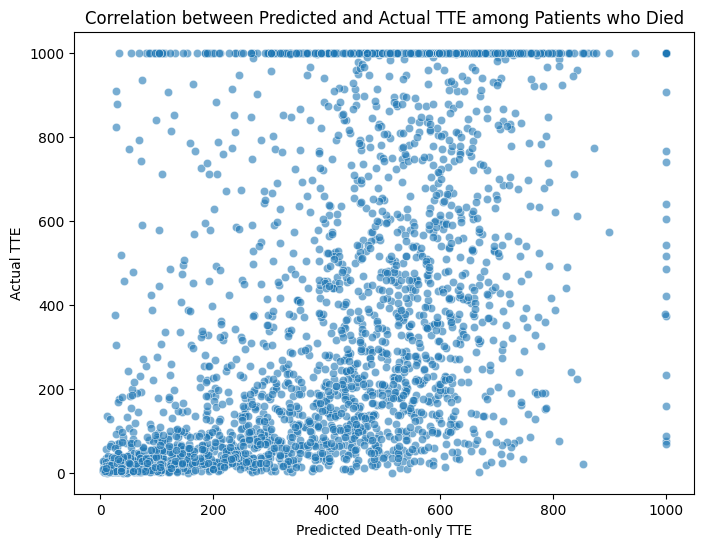

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to patients who died (assuming outcome==0 indicates death)
df_died = real_df[real_df['outcome'] == 0].copy()

# Calculate Pearson and Spearman correlations among patients who died
pearson_corr_died = df_died['predicted_death_only_tte'].corr(df_died['tte'], method='pearson')
spearman_corr_died = df_died['predicted_death_only_tte'].corr(df_died['tte'], method='spearman')

print("Among patients who died:")
print("Pearson correlation between predicted TTE and actual tte:", pearson_corr_died)
print("Spearman correlation between predicted TTE and actual tte:", spearman_corr_died)

# Create a scatter plot for patients who died
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_died['predicted_death_only_tte'], y=df_died['tte'], alpha=0.6)
plt.xlabel("Predicted Death-only TTE")
plt.ylabel("Actual TTE")
plt.title("Correlation between Predicted and Actual TTE among Patients who Died")
plt.show()


In [124]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis over multiple time points (assumed to be stored in time_points)
hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_only_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_only_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_only_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_only_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.646          0.909             0.925
1    14           0.649          0.909             0.928
2    30           0.629          0.900             0.927
3    90           0.563          0.865             0.911
4   180           0.527          0.838             0.896
5   360           0.499          0.815             0.882

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      1.004     1.236       0.0      0.0
1    14      1.004     1.253       0.0      0.0
2    30      1.004     1.269       0.0      0.0
3    90      1.004     1.274       0.0      0.0
4   180      1.004     1.270       0.0      0.0
5   360      1.004     1.262       0.0      0.0


In [125]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

def prepare_cause_specific_data(df, max_time=None):
    """
    Prepare cause-specific data for DEATH as the event, ignoring transplant.
    Transplant (outcome=2) is treated as censoring.
    """
    analysis_df = df.copy()

    # event=1 if outcome is death (0), else 0
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)

    if max_time is not None:
        # Censor at max_time
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0  # censored if we haven't died by max_time
    return analysis_df

time_points = [7, 14, 30, 90, 180, 360]
hazard_results = []

for t in time_points:
    # Prepare cause-specific data for death (transplant=2 is considered censoring).
    analysis_df = prepare_cause_specific_data(real_df, max_time=t)

    # Model 1: predicted TTE only
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_death_only_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # Model 2: MELD3 only
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # Model 3: Combined
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_death_only_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    summary = cph_combined.summary
    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_death_only_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_death_only_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)
print("\nCause-Specific Hazard for Death (Transplant=2 as censoring) - Concordance Indices:")
print(results_df[['Time','c_index_metric','c_index_meld3','c_index_combined']].round(3))
print("\nHazard Ratios from Combined Model:")
print(results_df[['Time','hr_metric','hr_meld3','p_metric','p_meld3']].round(3))



Cause-Specific Hazard for Death (Transplant=2 as censoring) - Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.646          0.909             0.925
1    14           0.649          0.909             0.928
2    30           0.629          0.900             0.927
3    90           0.563          0.865             0.911
4   180           0.527          0.838             0.896
5   360           0.499          0.815             0.882

Hazard Ratios from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      1.004     1.236       0.0      0.0
1    14      1.004     1.253       0.0      0.0
2    30      1.004     1.269       0.0      0.0
3    90      1.004     1.274       0.0      0.0
4   180      1.004     1.270       0.0      0.0
5   360      1.004     1.262       0.0      0.0


In [111]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

# Create categorical variable for predicted_death_only_tte using specified bins.
bins = [0, 30, 90, 180, 360, np.inf]
labels = ['<30', '30-90', '90-180', '180-360', '>360']
real_df['predicted_death_only_tte_cat'] = pd.cut(real_df['predicted_death_only_tte'],
                                                  bins=bins,
                                                  labels=labels,
                                                  right=False)

# Optionally, view counts by category.
print("Counts by predicted TTE category:")
print(real_df['predicted_death_only_tte_cat'].value_counts().sort_index())

# Prepare survival data (assuming prepare_data function is defined)
analysis_df = prepare_data(real_df, t=90)

# Create a new DataFrame with the necessary variables.
# We'll include 'tte' (time-to-event), 'death_event' (1 for death, 0 for censoring/transplant),
# 'meld3', and the new categorical predicted TTE.
data = analysis_df[['tte', 'death_event', 'predicted_death_only_tte_cat']].copy()

# Convert the categorical variable into dummy variables.
# drop_first=True will use the first category ('<30') as the reference.
data = pd.get_dummies(data, columns=['predicted_death_only_tte_cat'], drop_first=True)

# Fit the Cox proportional hazards model including MELD3 and the dummy variables.
cph = CoxPHFitter()
cph.fit(data, duration_col='tte', event_col='death_event', show_progress=False)

# Print the summary of the model.
print("\nCox Model Summary with MELD3 and predicted_death_only_tte categorical:")
print(cph.summary)


Counts by predicted TTE category:
predicted_death_only_tte_cat
<30        3531
30-90      2570
90-180     2989
180-360    4072
>360       2719
Name: count, dtype: int64

Cox Model Summary with MELD3 and predicted_death_only_tte categorical:
                                          coef  exp(coef)  se(coef)  \
covariate                                                             
predicted_death_only_tte_cat_30-90   -0.113084   0.893076  0.099859   
predicted_death_only_tte_cat_90-180  -1.256000   0.284791  0.112845   
predicted_death_only_tte_cat_180-360 -1.534224   0.215623  0.108168   
predicted_death_only_tte_cat_>360    -1.488696   0.225667  0.114919   

                                      coef lower 95%  coef upper 95%  \
covariate                                                              
predicted_death_only_tte_cat_30-90         -0.308805        0.082637   
predicted_death_only_tte_cat_90-180        -1.477172       -1.034829   
predicted_death_only_tte_cat_180-360       -

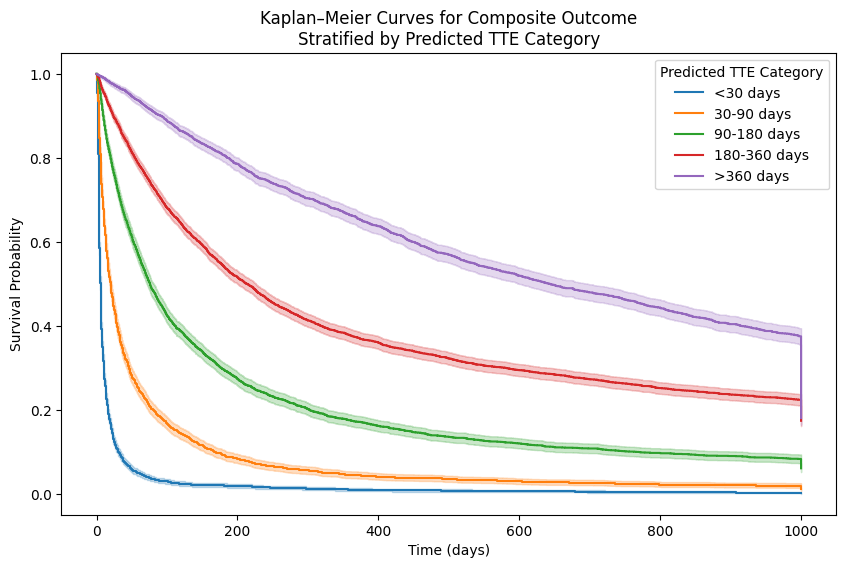

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

# Define bins and labels for the predicted TTE.
bins = [0, 30, 90, 180, 360, np.inf]
labels = ['<30 days', '30-90 days', '90-180 days', '180-360 days', '>360 days']

# Create a categorical variable for the predicted TTE.
# (Assume your composite weighted TTE is stored in 'predicted_death_only_tte')
real_df['predicted_tte_category'] = pd.cut(real_df['predicted_death_only_tte'],
                                            bins=bins,
                                            labels=labels,
                                            right=False)

# Prepare composite survival data:
# Here, we define an event as having either died (outcome==0) or been transplanted (outcome==2).
def prepare_composite_survival_data(df, max_time=None):
    """
    Prepare survival data for composite outcomes.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame with a composite event indicator.
    """
    analysis_df = df.copy()
    # Create composite event: 1 if outcome is death (0) or transplant (2), else 0.
    analysis_df['event'] = analysis_df['outcome'].isin([0, 2]).astype(int)

    # If a max_time is specified, censor patients who exceed that time.
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'event'] = 0
    return analysis_df

# Prepare the data; here we use the full follow-up (no cutoff) or you can specify a max_time if desired.
analysis_df = prepare_composite_survival_data(real_df)

# Plot Kaplan–Meier curves stratified by the predicted TTE category.
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for cat in labels:
    mask = analysis_df['predicted_tte_category'] == cat
    if mask.sum() > 0:
        kmf.fit(analysis_df.loc[mask, 'tte'], event_observed=analysis_df.loc[mask, 'event'], label=cat)
        kmf.plot(ci_show=True)
plt.title("Kaplan–Meier Curves for Composite Outcome\nStratified by Predicted TTE Category")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend(title="Predicted TTE Category")
plt.show()


In [121]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# Define the time points at which to evaluate
time_points = [7, 14, 30, 90, 180, 360]

# Make a copy of the data to avoid modifying the original
df_all = real_df.copy()

# We'll store results here
results = []

for t in time_points:
    # 1. Define the at-risk set:
    #    patients who are still under observation at time t (tte >= t)
    #    or had the composite event (death=0 or transplant=2) by time t (tte <= t).
    at_risk_mask = (
        (df_all['tte'] >= t) |
        ((df_all['outcome'].isin([0, 2])) & (df_all['tte'] <= t))
    )
    df_at_risk = df_all[at_risk_mask].copy()

    # 2. Among the at-risk set, define the event indicator at time t:
    #    1 if the patient had death or transplant by t, 0 otherwise.
    event_mask = (
        (df_at_risk['outcome'].isin([0, 2])) &
        (df_at_risk['tte'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 3. Define risk scores:
    #    - For predicted TTE, a lower TTE means higher risk, so we use the negative as the risk score.
    #      Replace 'predicted_composite_tte' with your actual column name if needed.
    risk_pred = -df_at_risk['predicted_death_only_tte']

    #    - For MELD3, a higher score indicates higher risk, so we use it directly.
    risk_meld3 = df_at_risk['meld3']

    # 4. Compute AUC if there is at least one event and one non-event in this subset.
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_pred = roc_auc_score(event_indicator, risk_pred)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_pred = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events': event_indicator.sum(),
        'AUC_predicted': auc_pred,
        'AUC_meld3': auc_meld3
    })

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
print("\nNaive Time-Dependent AUC (Death or Transplant) Comparison:")
print(results_df)



Naive Time-Dependent AUC (Death or Transplant) Comparison:
   Time  N_at_risk  N_events  AUC_predicted  AUC_meld3
0     7      15877      3194       0.882714   0.884009
1    14      15869      4571       0.889540   0.885309
2    30      15843      6139       0.894132   0.882665
3    90      15776      8609       0.883958   0.858389
4   180      15691     10245       0.878639   0.841877
5   360      15584     11770       0.879783   0.829922


COMPOSITE

In [126]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 50       # Number of closest neighbors with composite event (death or transplant)
ALPHA = 1e-6      # Small constant to avoid division by zero in weights

def compute_weighted_composite_tte(idx):
    """
    Compute a weighted average tte based on the top TOP_K neighbors
    with a composite event (outcome 0 or 2). Weights are 1/(distance + ALPHA).
    If fewer than TOP_K neighbors experienced an event, we use however many did.
    If none did, we fallback to the median tte of all neighbors.
    """
    # Retrieve neighbor indices and distances for this real patient
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame of neighbor data
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    # Filter neighbors to those with composite events (death=0 or transplant=2)
    composite_neighbors = neighbors[neighbors['outcome'].isin([0, 2])].sort_values('dist')

    # Take the top TOP_K composite event neighbors
    selected = composite_neighbors.head(TOP_K)

    if len(selected) > 0:
        # Compute inverse-distance weights
        weights = 1.0 / (selected['dist'] + ALPHA)
        tte_values = selected['tte']
        weighted_tte = (weights * tte_values).sum() / weights.sum()
        return weighted_tte
    else:
        # Fallback: if no neighbor experienced a composite event, use the median tte of all neighbors.
        return np.median(neighbors['tte'].values)

# Number of real patients is assumed to be available from your precomputed indices_all.
n_real = indices_all.shape[0]

# Compute the weighted composite tte for each real patient in parallel with a progress bar.
with tqdm_joblib(tqdm(desc="Computing weighted composite TTE", total=n_real)) as progress_bar:
    predicted_composite_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )

predicted_composite_tte = np.array(predicted_composite_tte)

# Store the predictions in your real_df.
real_df['predicted_death_only_tte'] = predicted_composite_tte

# Optional: Display a sample of the predictions.
print(real_df[['predicted_death_only_tte']].head())



Computing weighted composite TTE:   0%|          | 0/15881 [00:00<?, ?it/s]

  0%|          | 0/15881 [00:00<?, ?it/s]

   predicted_death_only_tte
0                529.797688
1                 30.272879
2                711.391366
3                310.287635
4                260.529916


Among patients who either died or got transplanted:
Pearson correlation between predicted TTE and actual tte: 0.5980594935672047
Spearman correlation between predicted TTE and actual tte: 0.7162652233113741


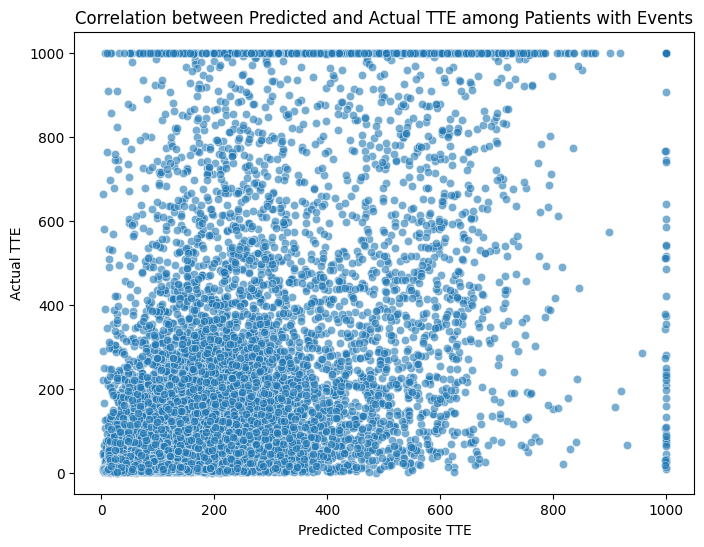

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to patients who experienced an event: either death (0) or transplant (2)
df_events = real_df[real_df['outcome'].isin([0, 2])].copy()

# Calculate Pearson and Spearman correlations among patients with events
pearson_corr_events = df_events['predicted_death_only_tte'].corr(df_events['tte'], method='pearson')
spearman_corr_events = df_events['predicted_death_only_tte'].corr(df_events['tte'], method='spearman')

print("Among patients who either died or got transplanted:")
print("Pearson correlation between predicted TTE and actual tte:", pearson_corr_events)
print("Spearman correlation between predicted TTE and actual tte:", spearman_corr_events)

# Create a scatter plot for patients who experienced events
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_events['predicted_death_only_tte'], y=df_events['tte'], alpha=0.6)
plt.xlabel("Predicted Composite TTE")
plt.ylabel("Actual TTE")
plt.title("Correlation between Predicted and Actual TTE among Patients with Events")
plt.show()


In [109]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.788          0.909             0.913
1    14           0.791          0.909             0.913
2    30           0.778          0.900             0.906
3    90           0.717          0.865             0.875
4   180           0.679          0.838             0.852
5   360           0.652          0.815             0.830

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      1.000     1.201     0.786      0.0
1    14      1.001     1.216     0.263      0.0
2    30      1.001     1.229     0.003      0.0
3    90      1.001     1.226     0.000      0.0
4   180      1.001     1.219     0.000      0.0
5   360      1.001     1.207     0.000      0.0


Weighted Average

In [127]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Configuration
TOP_K = 100       # Use the 100 closest neighbors
ALPHA = 1e-6      # Small constant to avoid division by zero

def compute_weighted_composite_tte(idx):
    """
    Compute a composite weighted average tte based on the TOP_K nearest neighbors.
    For each outcome group (0: death, 1: waiting, 2: transplant):
      - Compute a weighted average tte using inverse-distance weighting.
      - Compute the proportion of neighbors in that group.
    The final predicted tte is the sum of each group's (weighted average tte × proportion).

    If a given group is absent, its contribution is 0.
    """
    # Retrieve neighbor indices and distances for this real patient.
    neighbor_idxs = indices_all[idx]
    neighbor_dists = distances_all[idx]

    # Build a DataFrame for these neighbors.
    neighbors = syn_df_processed.loc[neighbor_idxs].copy()
    neighbors['dist'] = neighbor_dists

    total_neighbors = len(neighbors)
    composite_tte = 0.0

    # Loop over each outcome group: 0, 1, 2.
    for outcome in [0, 1, 2]:
        # Get subset for this outcome (if any)
        subset = neighbors[neighbors['outcome'] == outcome]
        if len(subset) > 0:
            # Use only the TOP_K closest neighbors within this outcome group.
            subset = subset.sort_values('dist').head(TOP_K)
            # Compute inverse-distance weights.
            weights = 1.0 / (subset['dist'] + ALPHA)
            weighted_avg = (weights * subset['tte']).sum() / weights.sum()
            proportion = len(subset) / total_neighbors
            composite_tte += weighted_avg * proportion
        else:
            # No neighbors in this group contribute.
            composite_tte += 0.0
    return composite_tte

# Number of real patients (assumed available from indices_all)
n_real = indices_all.shape[0]

# Compute the composite predicted TTE for each real patient in parallel.
with tqdm_joblib(tqdm(desc="Computing composite weighted TTE", total=n_real)) as progress_bar:
    predicted_tte = Parallel(n_jobs=-1, backend="threading")(
        delayed(compute_weighted_composite_tte)(i) for i in range(n_real)
    )
predicted_tte = np.array(predicted_tte)

# Store the predictions in your real_df under a new column.
real_df['predicted_composite_tte'] = predicted_tte

# Optional: display a sample of the predictions.
print(real_df[['predicted_composite_tte']].head())




Computing composite weighted TTE:   0%|          | 0/15881 [00:00<?, ?it/s]

  0%|          | 0/15881 [00:00<?, ?it/s]

   predicted_composite_tte
0               559.255310
1                30.101172
2               709.343642
3               321.540421
4               259.385571


In [128]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from tqdm.notebook import tqdm

def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data.
        max_time: Optional maximum follow-up time to consider.

    Returns:
        DataFrame prepared for survival analysis.
    """
    analysis_df = df.copy()
    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome'] == 0).astype(int)
    # If max_time is specified, censor patients who survive past max_time
    if max_time is not None:
        mask = analysis_df['tte'] > max_time
        analysis_df.loc[mask, 'tte'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0
    return analysis_df

# Assume time_points is defined, e.g.:
time_points = [7, 14, 30, 90, 180, 360]

hazard_results = []

for t in time_points:
    # Prepare survival data for the current time point
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using predicted_composite_tte only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['tte', 'death_event', 'predicted_composite_tte']].copy()
    cph_metric.fit(data_metric, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['tte', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['tte', 'death_event', 'predicted_composite_tte', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='tte', event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from the combined model summary.
    # Here we assume that the row label for our composite TTE predictor is 'predicted_composite_tte'
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['predicted_composite_tte', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['predicted_composite_tte', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print the results in a formatted way.
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))



Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.786          0.909             0.916
1    14           0.783          0.909             0.918
2    30           0.765          0.900             0.914
3    90           0.700          0.865             0.892
4   180           0.663          0.838             0.872
5   360           0.637          0.815             0.854

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      1.002     1.217     0.016      0.0
1    14      1.002     1.236     0.000      0.0
2    30      1.003     1.254     0.000      0.0
3    90      1.003     1.263     0.000      0.0
4   180      1.003     1.260     0.000      0.0
5   360      1.003     1.249     0.000      0.0


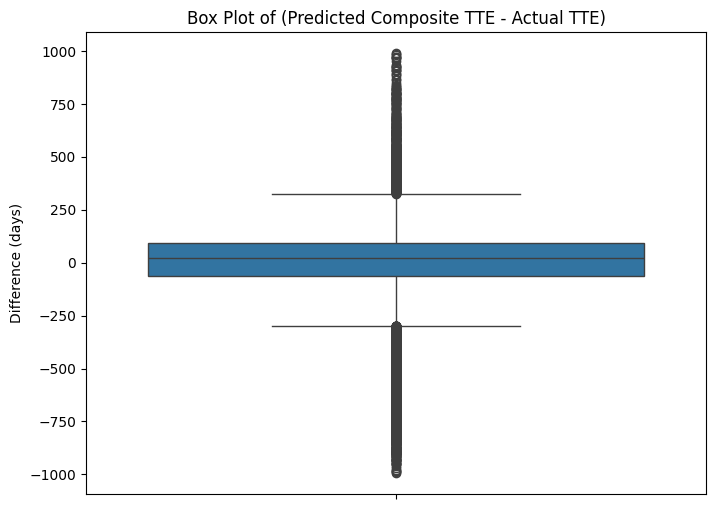

Summary Statistics for (Predicted Composite TTE - Actual TTE):
Mean Difference: -22.71 days
Median Difference: 20.26 days
Standard Deviation: 253.44 days
Mean Absolute Error (MAE): 163.78 days
Root Mean Squared Error (RMSE): 254.44 days

Correlation between Predicted Composite TTE and Actual TTE:
Pearson Correlation: 0.659
Spearman Correlation: 0.756


In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the difference between predicted composite TTE and actual TTE.
real_df['difference'] = real_df['predicted_composite_tte'] - real_df['tte']

# Plot a box plot of the differences.
plt.figure(figsize=(8, 6))
sns.boxplot(y=real_df['difference'])
plt.title("Box Plot of (Predicted Composite TTE - Actual TTE)")
plt.ylabel("Difference (days)")
plt.show()

# Calculate summary statistics for the differences.
mean_diff = real_df['difference'].mean()
median_diff = real_df['difference'].median()
std_diff = real_df['difference'].std()
mae = real_df['difference'].abs().mean()
rmse = np.sqrt((real_df['difference'] ** 2).mean())

print("Summary Statistics for (Predicted Composite TTE - Actual TTE):")
print(f"Mean Difference: {mean_diff:.2f} days")
print(f"Median Difference: {median_diff:.2f} days")
print(f"Standard Deviation: {std_diff:.2f} days")
print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")

# Additionally, calculate the correlation between predicted and actual TTE.
pearson_corr = real_df['predicted_composite_tte'].corr(real_df['tte'], method='pearson')
spearman_corr = real_df['predicted_composite_tte'].corr(real_df['tte'], method='spearman')

print("\nCorrelation between Predicted Composite TTE and Actual TTE:")
print(f"Pearson Correlation: {pearson_corr:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")


Previous Versions

In [ ]:
# Assume syn_embeddings and real_embeddings have been computed already.
print("Synthetic embeddings shape:", syn_embeddings.shape)
print("Real embeddings shape:", real_embeddings.shape)

# Create separate indices for each outcome group in synthetic data
syn_indices_by_outcome = {}
for outcome in ['0', '1', '2']:
    indices = np.where(syn_df_processed['outcome'].astype(str) == outcome)[0]
    syn_indices_by_outcome[outcome] = indices
    print(f"Outcome {outcome} has {len(indices)} synthetic samples")

# Set number of neighbors to retrieve
n_neighbors = 100

# Initialize arrays to store results for all real patients
distances_metric = np.zeros((len(real_df), n_neighbors))
indices_metric = np.zeros((len(real_df), n_neighbors), dtype=int)

# Process each outcome group separately
for outcome in ['0', '1', '2']:
    # Get indices of real patients with this outcome
    real_outcome_mask = real_df['outcome_encoded'].astype(str) == outcome
    real_indices = np.where(real_outcome_mask)[0]

    if len(real_indices) == 0:
        continue  # Skip if no real patient with this outcome

    # Retrieve embeddings for these real patients and the corresponding synthetic ones
    real_outcome_embeddings = real_embeddings[real_indices]
    syn_outcome_embeddings = syn_embeddings[syn_indices_by_outcome[outcome]]

    # Fit and perform nearest neighbor search for this outcome group
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto')
    nbrs.fit(syn_outcome_embeddings)
    distances, indices = nbrs.kneighbors(real_outcome_embeddings)

    # Map neighbor indices back to the original synthetic dataset indices
    indices = syn_indices_by_outcome[outcome][indices]

    # Store the computed distances and indices for these real patients
    distances_metric[real_indices] = distances
    indices_metric[real_indices] = indices

print("Nearest neighbor search complete. indices_metric shape:", indices_metric.shape)

# Define syn_target from synthetic dataframe (adjust the column name if needed)
syn_target = syn_df_processed['time_to_event'].values

# Compute the median time-to-event for each real patient based on their synthetic neighbors
median_time_list_metric = []
for i in range(indices_metric.shape[0]):
    neighbor_times = syn_target[indices_metric[i]]
    median_time = np.median(neighbor_times)
    median_time_list_metric.append(median_time)
median_time_array_metric = np.array(median_time_list_metric)

# Add predicted median time-to-event to the real dataframe
real_df['median_time_to_event_metric'] = median_time_array_metric

print("\nSample real data with actual vs. predicted time-to-event:")
print(real_df[['outcome_encoded', 'time_to_event', 'median_time_to_event_metric']].head())


Synthetic embeddings shape: (10000000, 64)
Real embeddings shape: (18328, 64)
Outcome 0 has 1620302 synthetic samples
Outcome 1 has 2280287 synthetic samples
Outcome 2 has 6099411 synthetic samples
Nearest neighbor search complete. indices_metric shape: (18328, 100)

Sample real data with actual vs. predicted time-to-event:
   outcome_encoded  time_to_event  median_time_to_event_metric
0                2           15.0                    18.650199
1                0          668.0                   224.590768
2                2           39.0                    53.997809
3                2          437.0                    73.000000
4                0          703.0                   576.903330


In [ ]:
# Previous code remains the same up until after indices_metric computation...
from scipy import stats
# Compute both median and mode time-to-event for each real patient based on their synthetic neighbors
median_time_list_metric = []

for i in range(indices_metric.shape[0]):
    neighbor_times = syn_target[indices_metric[i]]

    # Calculate median
    median_time = np.median(neighbor_times)
    median_time_list_metric.append(median_time)


median_time_array_metric = np.array(median_time_list_metric)

# Add both predicted times to the real dataframe
real_df['median_time_to_event_metric'] = median_time_array_metric


print("\nSample real data with actual vs. predicted times:")
print(real_df[['outcome_encoded', 'time_to_event',
               'median_time_to_event_metric']].head())


Sample real data with actual vs. predicted times:
   outcome_encoded  time_to_event  median_time_to_event_metric
0                2           15.0                    18.650199
1                0          668.0                   224.590768
2                2           39.0                    53.997809
3                2          437.0                    73.000000
4                0          703.0                   576.903330


In [ ]:
def calculate_meld3(row):
    # Determine if female (1 if F, 0 otherwise)
    female = 1 if row['GENDER'] == 'F' else 0

    # Apply lower/upper bounds as needed
    bilirubin = max(1.0, row['INIT_BILIRUBIN'])
    sodium = min(137, max(125, row['INIT_SERUM_SODIUM']))
    inr = max(1.0, row['INIT_INR'])

    # Set creatinine based on dialysis status
    if row['INIT_DIALYSIS_PRIOR_WEEK'] == 'Y':
        creatinine = 3.0
    else:
        creatinine = min(3.0, max(1.0, row['INIT_SERUM_CREAT']))

    albumin = min(3.5, max(1.5, row['INIT_ALBUMIN']))

    # Calculate components
    female_component = 1.33 * female
    bilirubin_component = 4.56 * np.log(bilirubin)
    sodium_component = 0.82 * (137 - sodium)
    interaction1 = -0.24 * (137 - sodium) * np.log(bilirubin)
    inr_component = 9.09 * np.log(inr)
    creatinine_component = 11.14 * np.log(creatinine)
    albumin_component = 1.85 * (3.5 - albumin)
    interaction2 = -1.83 * (3.5 - albumin) * np.log(creatinine)
    constant = 6

    # Sum all components to get the MELD3 score and round it
    meld3 = (female_component + bilirubin_component + sodium_component +
             interaction1 + inr_component + creatinine_component +
             albumin_component + interaction2 + constant)
    return round(meld3)

# Apply the function to add a new column 'meld3' to real_df
real_df['meld3'] = real_df.apply(calculate_meld3, axis=1)

# Display a sample of the resulting dataframe to verify
print(real_df[['GENDER', 'INIT_BILIRUBIN', 'INIT_SERUM_SODIUM', 'INIT_INR',
               'INIT_DIALYSIS_PRIOR_WEEK', 'INIT_SERUM_CREAT', 'INIT_ALBUMIN', 'meld3']].head())


  GENDER  INIT_BILIRUBIN  INIT_SERUM_SODIUM  INIT_INR  \
0      M            8.00              136.0      2.30   
1      F            6.20              136.0      2.00   
2      M            3.60              129.0      1.30   
3      M            2.10              127.0      1.50   
4      M            9.14              139.0      1.51   

  INIT_DIALYSIS_PRIOR_WEEK  INIT_SERUM_CREAT  INIT_ALBUMIN  meld3  
0                        N              1.14           1.6     28  
1                        N              0.74           2.5     24  
2                        N              1.60           2.8     24  
3                        N              0.80           2.8     21  
4                        N              0.60           3.0     21  


In [ ]:
from sklearn.metrics import auc
from lifelines import CoxPHFitter
from scipy import stats
from sklearn.metrics import roc_auc_score


def calculate_cumulative_incidence(times, events, predict_time):
    """Calculate cumulative incidence at specified time"""
    n_total = len(times)
    n_events = sum((events == 1) & (times <= predict_time))
    return n_events / n_total

def bootstrap_ci(metric_func, data, n_bootstrap=1000, alpha=0.05):
    """Calculate confidence intervals using bootstrapping"""
    bootstrap_estimates = []
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, len(data), len(data))
        bootstrap_sample = data.iloc[indices]
        estimate = metric_func(bootstrap_sample)
        bootstrap_estimates.append(estimate)

    ci_lower = np.percentile(bootstrap_estimates, alpha/2 * 100)
    ci_upper = np.percentile(bootstrap_estimates, (1-alpha/2) * 100)
    return ci_lower, ci_upper

In [ ]:
from sklearn.metrics import roc_auc_score

# Define time points for evaluation
time_points = [7, 14, 30, 90, 180, 360]
results = []

for t in time_points:
    # Create a mask to exclude transplants (assume outcome 2 is transplant)
    mask = real_df['outcome_encoded'].isin([0, 1])
    df_filtered = real_df[mask]

    # Create death indicator (1 if death occurred by time t, 0 if still waiting)
    death_indicator = ((df_filtered['outcome_encoded'] == 0) &
                       (df_filtered['time_to_event'] <= t)).astype(int)

    # Define risk scores (the lower the predicted median time, the higher the risk)
    risk_scores = -df_filtered['median_time_to_event_metric']

    # Calculate AUC for death prediction using the filtered dataset
    death_auc = roc_auc_score(death_indicator, risk_scores)

    # Calculate cumulative incidence on the full dataset (if desired) or on df_filtered
    n_death = death_indicator.sum()
    # For cumulative incidence, you might want to consider only those in df_filtered as well:
    n_total = len(df_filtered)
    death_ci = n_death / n_total

    results.append({
        'Time': t,
        'N_death': n_death,
        'N_total': n_total,
        'Death_rate': death_ci,
        'AUC': death_auc
    })

results_df = pd.DataFrame(results)
print("\nResults at different time points (excluding transplants):")
print(results_df)



Results at different time points (excluding transplants):
   Time  N_death  N_total  Death_rate       AUC
0     7      222     7053    0.031476  0.971179
1    14      360     7053    0.051042  0.973088
2    30      601     7053    0.085212  0.972781
3    90      961     7053    0.136254  0.960473
4   180     1285     7053    0.182192  0.952705
5   360     1732     7053    0.245569  0.954496


In [ ]:

from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Exclude transplants (outcome_encoded == 2)
df_filtered = real_df[real_df['outcome_encoded'].isin([0, 1])].copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - died on/before time t
    at_risk_mask = (
        (df_filtered['time_to_event'] >= t) |
        ((df_filtered['outcome_encoded'] == 0) & (df_filtered['time_to_event'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_filtered[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome_encoded'] == 0) &
        (df_at_risk['time_to_event'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    #    so we use the negative of that column.
    risk_metric = -df_at_risk['median_time_to_event_metric']

    #    For meld3, typically a higher meld3 => higher risk,
    #    so we can use it as is. (Adjust if your convention is reversed.)
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        # If we have all events or no events in this subset, AUC is not defined
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nNaive Time-Dependent AUC (Excluding Transplants):")
print(results_df)


Naive Time-Dependent AUC (Excluding Transplants):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7       7049            222    0.971162   0.947847
1    14       7039            360    0.973032   0.941957
2    30       7018            601    0.972632   0.925654
3    90       6931            961    0.959666   0.871485
4   180       6816           1285    0.950680   0.821405
5   360       6637           1732    0.950645   0.771982


In [ ]:
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

# 1. Include all patients (both events and censored)
df_all = real_df.copy()

for t in time_points:
    # 2. Define the "at-risk" set: those who are either
    #    - not yet censored by time t (time_to_event >= t), or
    #    - had an event (death or transplant) on/before time t
    at_risk_mask = (
        (df_all['time_to_event'] >= t) |
        ((df_all['outcome_encoded'].isin([0, 2])) & (df_all['time_to_event'] <= t))
    )

    # Filter the dataframe
    df_at_risk = df_all[at_risk_mask].copy()

    # 3. Among those at risk, define the event indicator:
    #    1 if death OR transplant occurred by time t, 0 otherwise
    event_mask = (
        (df_at_risk['outcome_encoded'].isin([0, 2])) &
        (df_at_risk['time_to_event'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # 4. Get risk scores
    #    For median_time_to_event_metric, lower predicted time => higher risk
    risk_metric = -df_at_risk['median_time_to_event_metric']
    risk_meld3 = df_at_risk['meld3']

    # We can only compute AUC if we have at least one event and one non-event
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nTime-Dependent AUC (Composite Outcome - Death or Transplant):")
print(results_df)


Time-Dependent AUC (Composite Outcome - Death or Transplant):
   Time  N_at_risk  N_events_by_t  AUC_metric  AUC_meld3
0     7      18324           3233    0.910310   0.884694
1    14      18314           4580    0.920310   0.886309
2    30      18293           6182    0.923493   0.876807
3    90      18206           8674    0.924621   0.840097
4   180      18091          10422    0.931272   0.812050
5   360      17912          11977    0.947426   0.788309


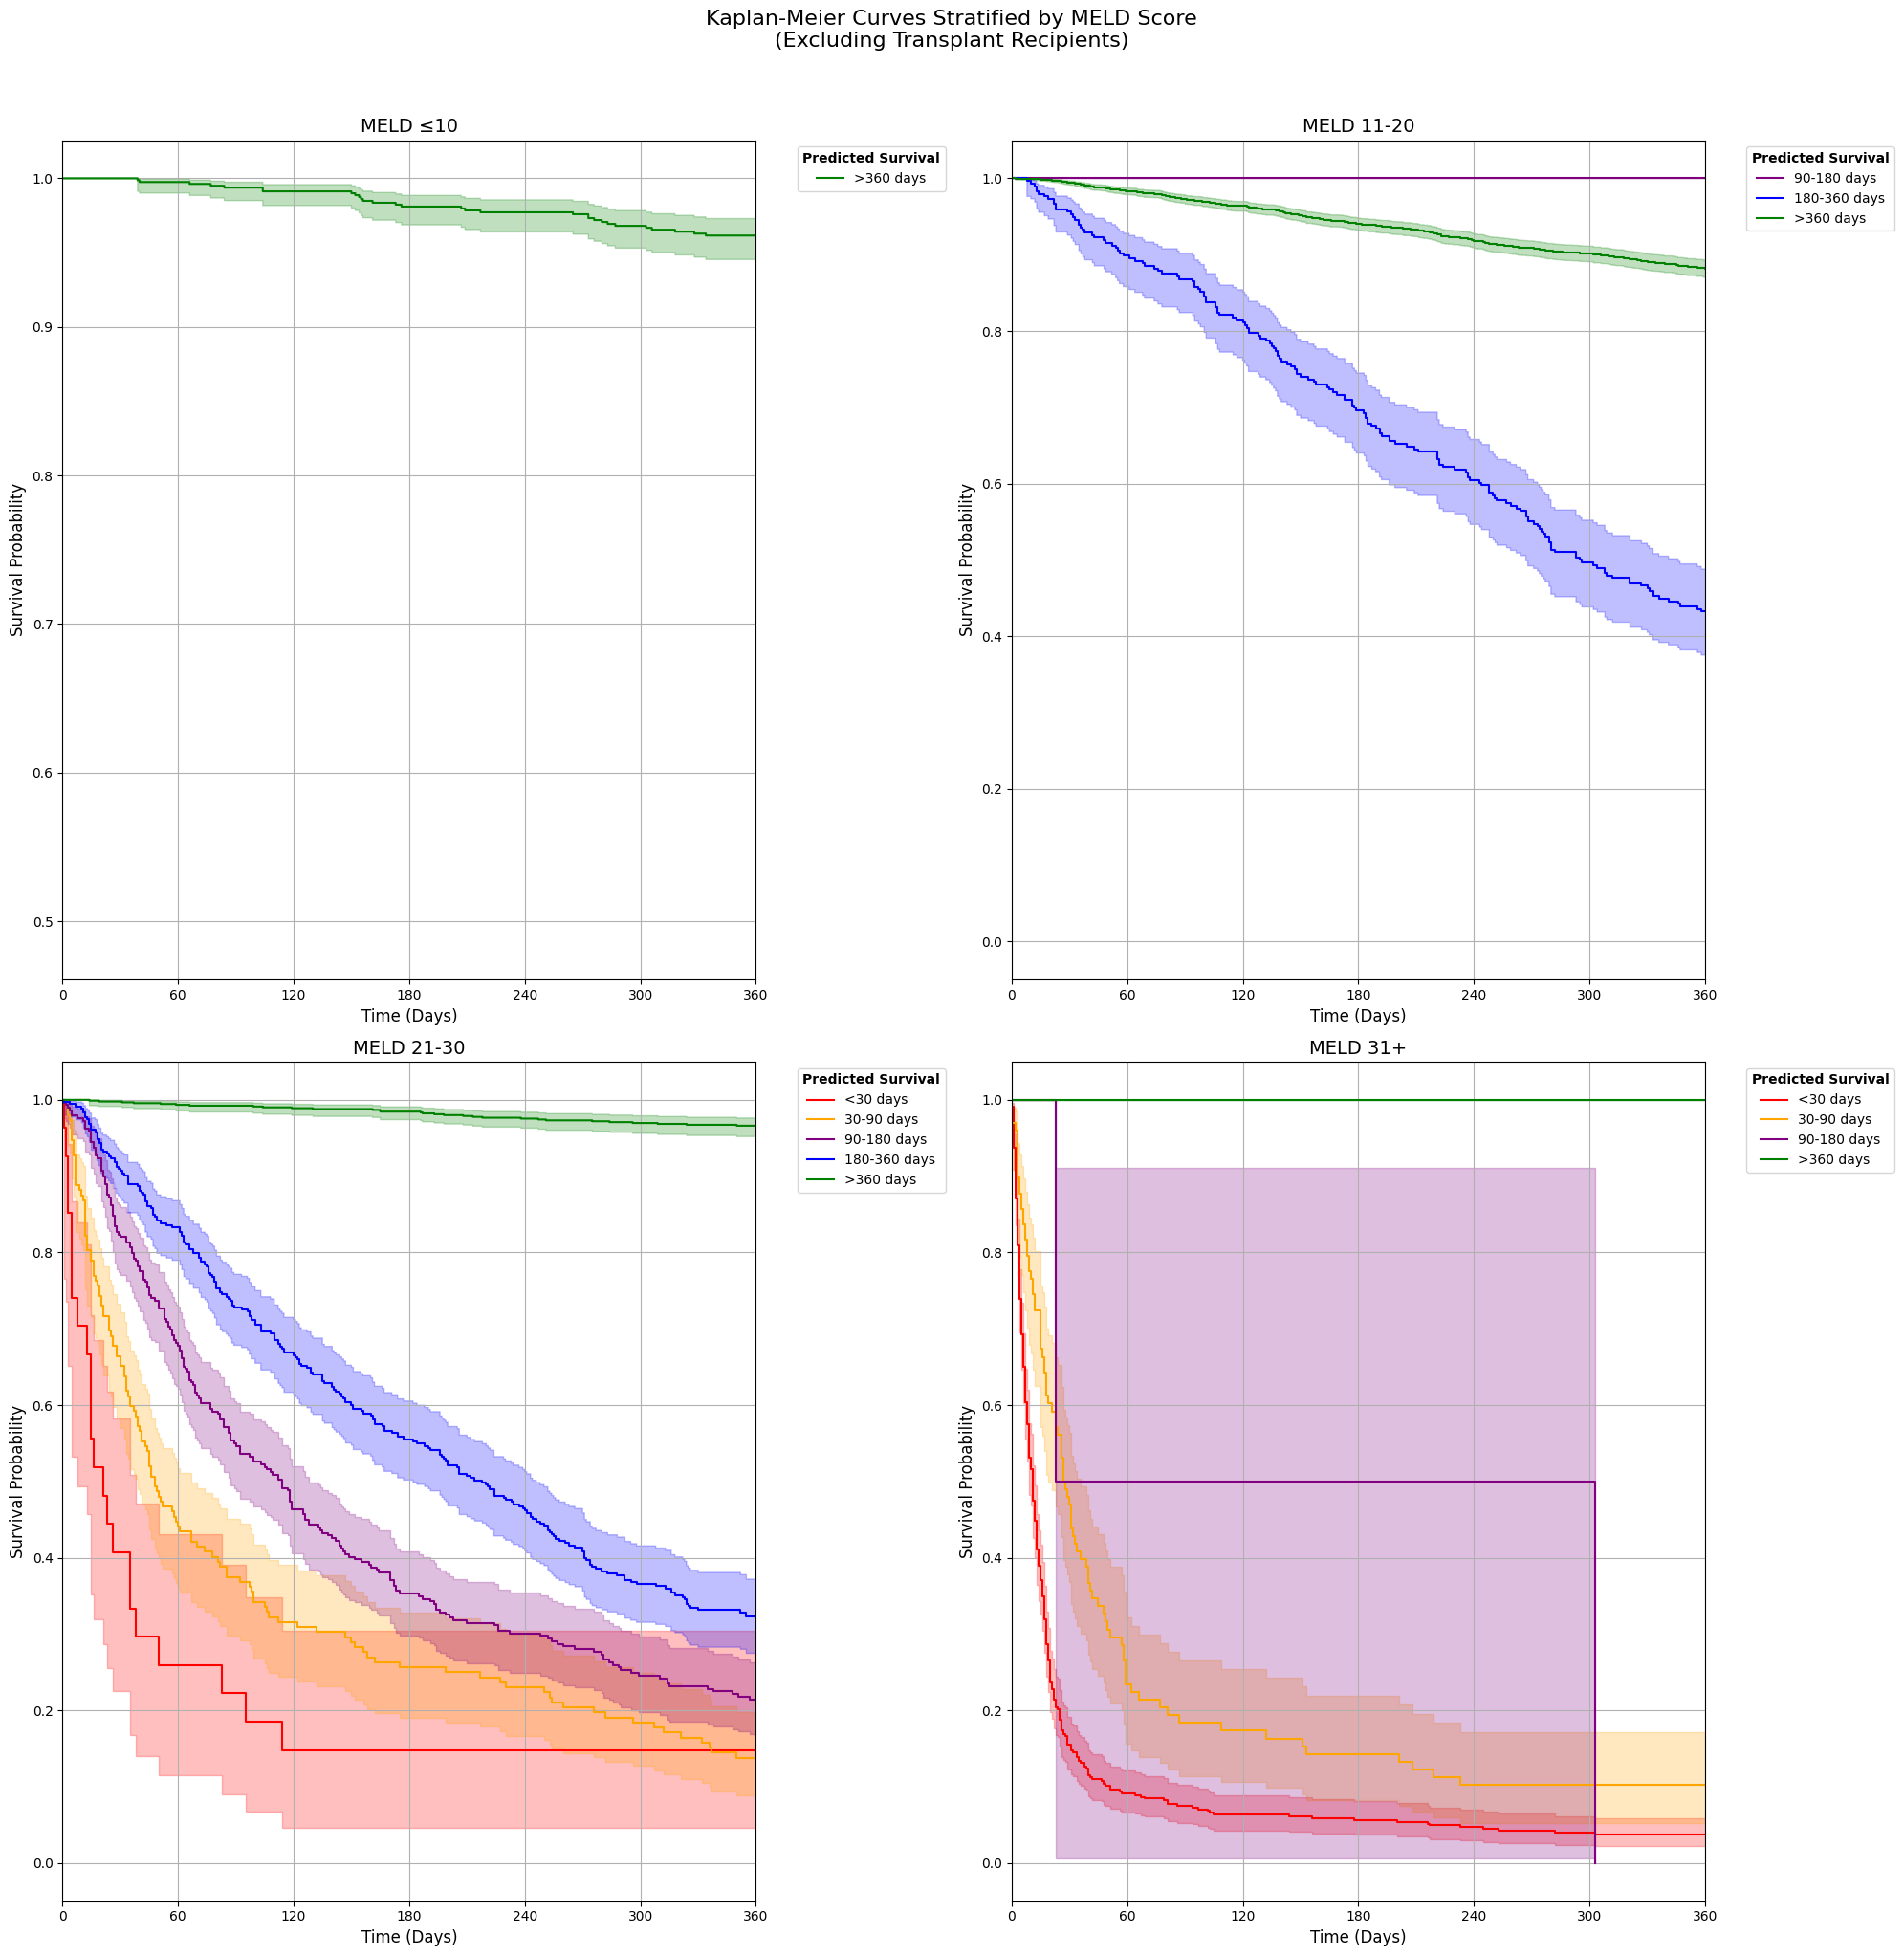


Detailed Statistics by MELD Category and Predicted Survival Group:
----------------------------------------------------------------------------------------------------
MELD Category   Predicted Survival N        Deaths   Median Survival   % Deaths
----------------------------------------------------------------------------------------------------
≤10             >360 days       811      201                  inf      24.8%
----------------------------------------------------------------------------------------------------
11-20           90-180 days     1        1                  698.0     100.0%
11-20           180-360 days    296      296                295.0     100.0%
11-20           >360 days       3413     1024              2925.0      30.0%
----------------------------------------------------------------------------------------------------
21-30           <30 days        27       27                  21.0     100.0%
21-30           30-90 days      152      152                 48

In [ ]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def get_time_category(time):
    if time < 30:
        return '<30 days'
    elif time < 90:
        return '30-90 days'
    elif time < 180:
        return '90-180 days'
    elif time < 360:
        return '180-360 days'
    else:
        return '>360 days'

def get_meld_category(meld):
    if meld <= 10:
        return '≤10'
    elif meld <= 20:
        return '11-20'
    elif meld <= 30:
        return '21-30'
    else:
        return '31+'

# Create copy of real_df and exclude transplants
analysis_df = real_df[real_df['outcome_encoded'] != 2].copy()

# Add time categories and MELD categories
analysis_df['time_category'] = analysis_df['median_time_to_event_metric'].apply(get_time_category)
analysis_df['meld_category'] = analysis_df['meld3'].apply(get_meld_category)

# Create death event indicator (1 for death, 0 for censoring)
analysis_df['death_event'] = (analysis_df['outcome_encoded'] == 0).astype(int)

# Define colors for consistent plotting
colors = {
    '<30 days': 'red',
    '30-90 days': 'orange',
    '90-180 days': 'purple',
    '180-360 days': 'blue',
    '>360 days': 'green'
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.ravel()

# Initialize KM fitter
kmf = KaplanMeierFitter()

# Create plots for each MELD category
for idx, meld_cat in enumerate(['≤10', '11-20', '21-30', '31+']):
    ax = axes[idx]

    # Get data for this MELD category
    meld_data = analysis_df[analysis_df['meld_category'] == meld_cat]

    # Plot each time category within this MELD category
    for time_cat in ['<30 days', '30-90 days', '90-180 days', '180-360 days', '>360 days']:
        mask = meld_data['time_category'] == time_cat
        if mask.sum() > 0:
            group_df = meld_data[mask]
            kmf.fit(
                group_df['time_to_event'],
                group_df['death_event'],
                label=f"{time_cat}"
            )
            kmf.plot(ci_show=True, color=colors[time_cat], ax=ax)

    # Customize subplot
    ax.set_xlabel('Time (Days)', fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.set_title(f'MELD {meld_cat}', fontsize=14)
    ax.grid(True)
    ax.set_xlim(0, 360)
    ax.set_xticks(np.arange(0, 361, 60))

    # Add legend with title
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Predicted Survival')
    legend.get_title().set_fontweight('bold')

# Add overall title
fig.suptitle('Kaplan-Meier Curves Stratified by MELD Score\n(Excluding Transplant Recipients)',
             fontsize=16, y=1.02)

# Adjust layout
plt.tight_layout()

# Save as PNG with 300 DPI
plt.savefig('kaplan_meier_survival_stratified.png', dpi=300, bbox_inches='tight', format='png')

# Save as TIFF with 300 DPI
plt.savefig('kaplan_meier_survival_stratified.tiff', dpi=300, bbox_inches='tight', format='tiff')

# Show the plot
plt.show()

# Close the figure to free memory
plt.close()

# Print statistics for each stratum
print("\nDetailed Statistics by MELD Category and Predicted Survival Group:")
print("-" * 100)
print(f"{'MELD Category':<15} {'Predicted Survival':<15} {'N':<8} {'Deaths':<8} {'Median Survival':>15} {'% Deaths':>10}")
print("-" * 100)

for meld_cat in ['≤10', '11-20', '21-30', '31+']:
    meld_data = analysis_df[analysis_df['meld_category'] == meld_cat]

    for time_cat in ['<30 days', '30-90 days', '90-180 days', '180-360 days', '>360 days']:
        mask = meld_data['time_category'] == time_cat
        if mask.sum() > 0:
            group_df = meld_data[mask]
            kmf.fit(group_df['time_to_event'], group_df['death_event'])
            n_total = len(group_df)
            n_deaths = sum(group_df['death_event'])
            median = kmf.median_survival_time_
            median_str = f"{median:.1f}" if median is not None else ">360"
            death_pct = (n_deaths / n_total) * 100

            print(f"{meld_cat:<15} {time_cat:<15} {n_total:<8} {n_deaths:<8} {median_str:>15} {death_pct:>9.1f}%")
    print("-" * 100)

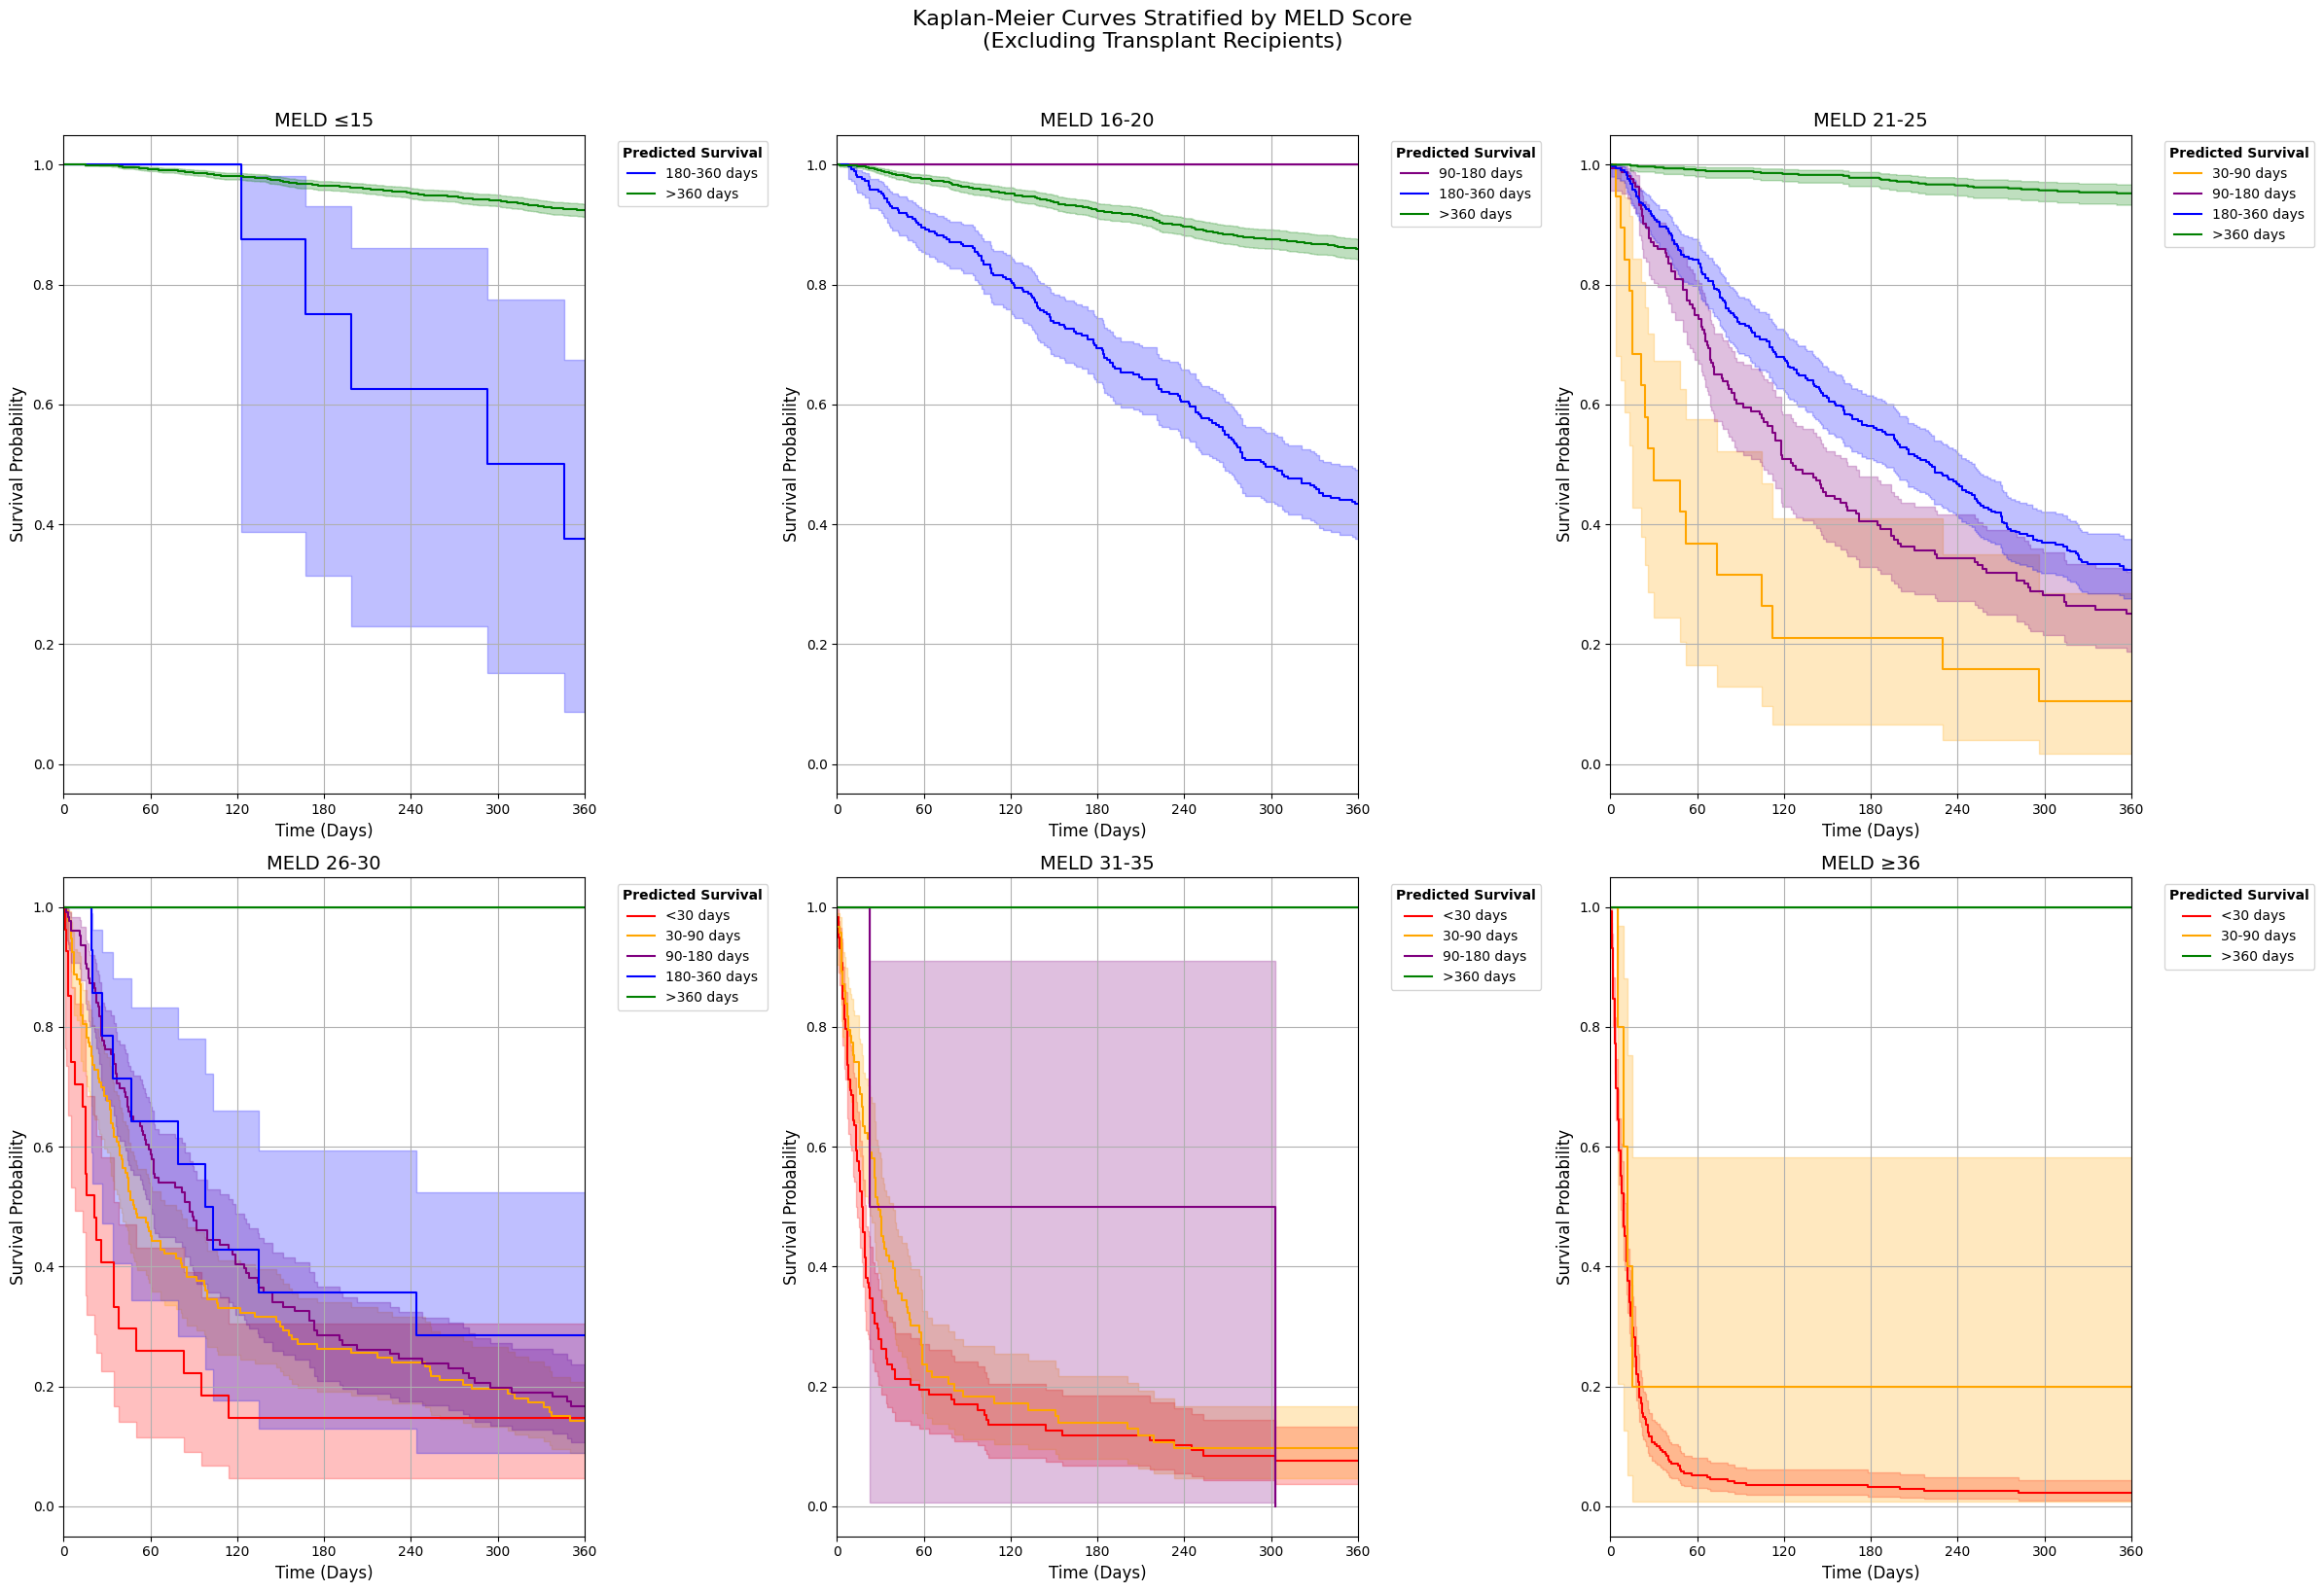


Detailed Statistics by MELD Category and Predicted Survival Group:
----------------------------------------------------------------------------------------------------
MELD Category   Predicted Survival N        Deaths   Median Survival   % Deaths
----------------------------------------------------------------------------------------------------
≤15             180-360 days    8        8                  346.0     100.0%
≤15             >360 days       2498     692               3032.0      27.7%
----------------------------------------------------------------------------------------------------
16-20           90-180 days     1        1                  698.0     100.0%
16-20           180-360 days    288      288                295.0     100.0%
16-20           >360 days       1726     533               2925.0      30.9%
----------------------------------------------------------------------------------------------------
21-25           30-90 days      19       19                  30

In [ ]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def get_time_category(time):
    if time < 30:
        return '<30 days'
    elif time < 90:
        return '30-90 days'
    elif time < 180:
        return '90-180 days'
    elif time < 360:
        return '180-360 days'
    else:
        return '>360 days'

def get_meld_category(meld):
    if meld <= 15:
        return '≤15'
    elif meld <= 20:
        return '16-20'
    elif meld <= 25:
        return '21-25'
    elif meld <= 30:
        return '26-30'
    elif meld <= 35:
        return '31-35'
    else:
        return '≥36'

# Create copy of real_df and exclude transplants
analysis_df = real_df[real_df['outcome_encoded'] != 2].copy()

# Add time categories and MELD categories
analysis_df['time_category'] = analysis_df['median_time_to_event_metric'].apply(get_time_category)
analysis_df['meld_category'] = analysis_df['meld3'].apply(get_meld_category)

# Create death event indicator (1 for death, 0 for censoring)
analysis_df['death_event'] = (analysis_df['outcome_encoded'] == 0).astype(int)

# Define colors for consistent plotting
colors = {
    '<30 days': 'red',
    '30-90 days': 'orange',
    '90-180 days': 'purple',
    '180-360 days': 'blue',
    '>360 days': 'green'
}

# Create subplots (2x3 grid)
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.ravel()

# Initialize KM fitter
kmf = KaplanMeierFitter()

# Create plots for each MELD category
meld_categories = ['≤15', '16-20', '21-25', '26-30', '31-35', '≥36']
time_categories = ['<30 days', '30-90 days', '90-180 days', '180-360 days', '>360 days']

for idx, meld_cat in enumerate(meld_categories):
    ax = axes[idx]

    # Get data for this MELD category
    meld_data = analysis_df[analysis_df['meld_category'] == meld_cat]

    # Plot each time category within this MELD category
    for time_cat in time_categories:
        mask = meld_data['time_category'] == time_cat
        if mask.sum() > 0:
            group_df = meld_data[mask]
            kmf.fit(
                group_df['time_to_event'],
                group_df['death_event'],
                label=f"{time_cat}"
            )
            kmf.plot(ci_show=True, color=colors[time_cat], ax=ax)

    # Customize subplot
    ax.set_xlabel('Time (Days)', fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.set_title(f'MELD {meld_cat}', fontsize=14)
    ax.grid(True)
    ax.set_xlim(0, 360)
    ax.set_xticks(np.arange(0, 361, 60))

    # Add legend with title
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Predicted Survival')
    legend.get_title().set_fontweight('bold')

# Add overall title
fig.suptitle('Kaplan-Meier Curves Stratified by MELD Score\n(Excluding Transplant Recipients)',
             fontsize=16, y=1.02)

# Adjust layout
plt.tight_layout()

# Save as PNG with 300 DPI
plt.savefig('kaplan_meier_survival_stratified.png', dpi=300, bbox_inches='tight', format='png')

# Save as TIFF with 300 DPI
plt.savefig('kaplan_meier_survival_stratified.tiff', dpi=300, bbox_inches='tight', format='tiff')

# Show the plot
plt.show()

# Close the figure to free memory
plt.close()

# Print statistics for each stratum
print("\nDetailed Statistics by MELD Category and Predicted Survival Group:")
print("-" * 100)
print(f"{'MELD Category':<15} {'Predicted Survival':<15} {'N':<8} {'Deaths':<8} {'Median Survival':>15} {'% Deaths':>10}")
print("-" * 100)

for meld_cat in meld_categories:
    meld_data = analysis_df[analysis_df['meld_category'] == meld_cat]

    for time_cat in time_categories:
        mask = meld_data['time_category'] == time_cat
        if mask.sum() > 0:
            group_df = meld_data[mask]
            kmf.fit(group_df['time_to_event'], group_df['death_event'])
            n_total = len(group_df)
            n_deaths = sum(group_df['death_event'])
            median = kmf.median_survival_time_
            median_str = f"{median:.1f}" if median is not None else ">360"
            death_pct = (n_deaths / n_total) * 100

            print(f"{meld_cat:<15} {time_cat:<15} {n_total:<8} {n_deaths:<8} {median_str:>15} {death_pct:>9.1f}%")
    print("-" * 100)

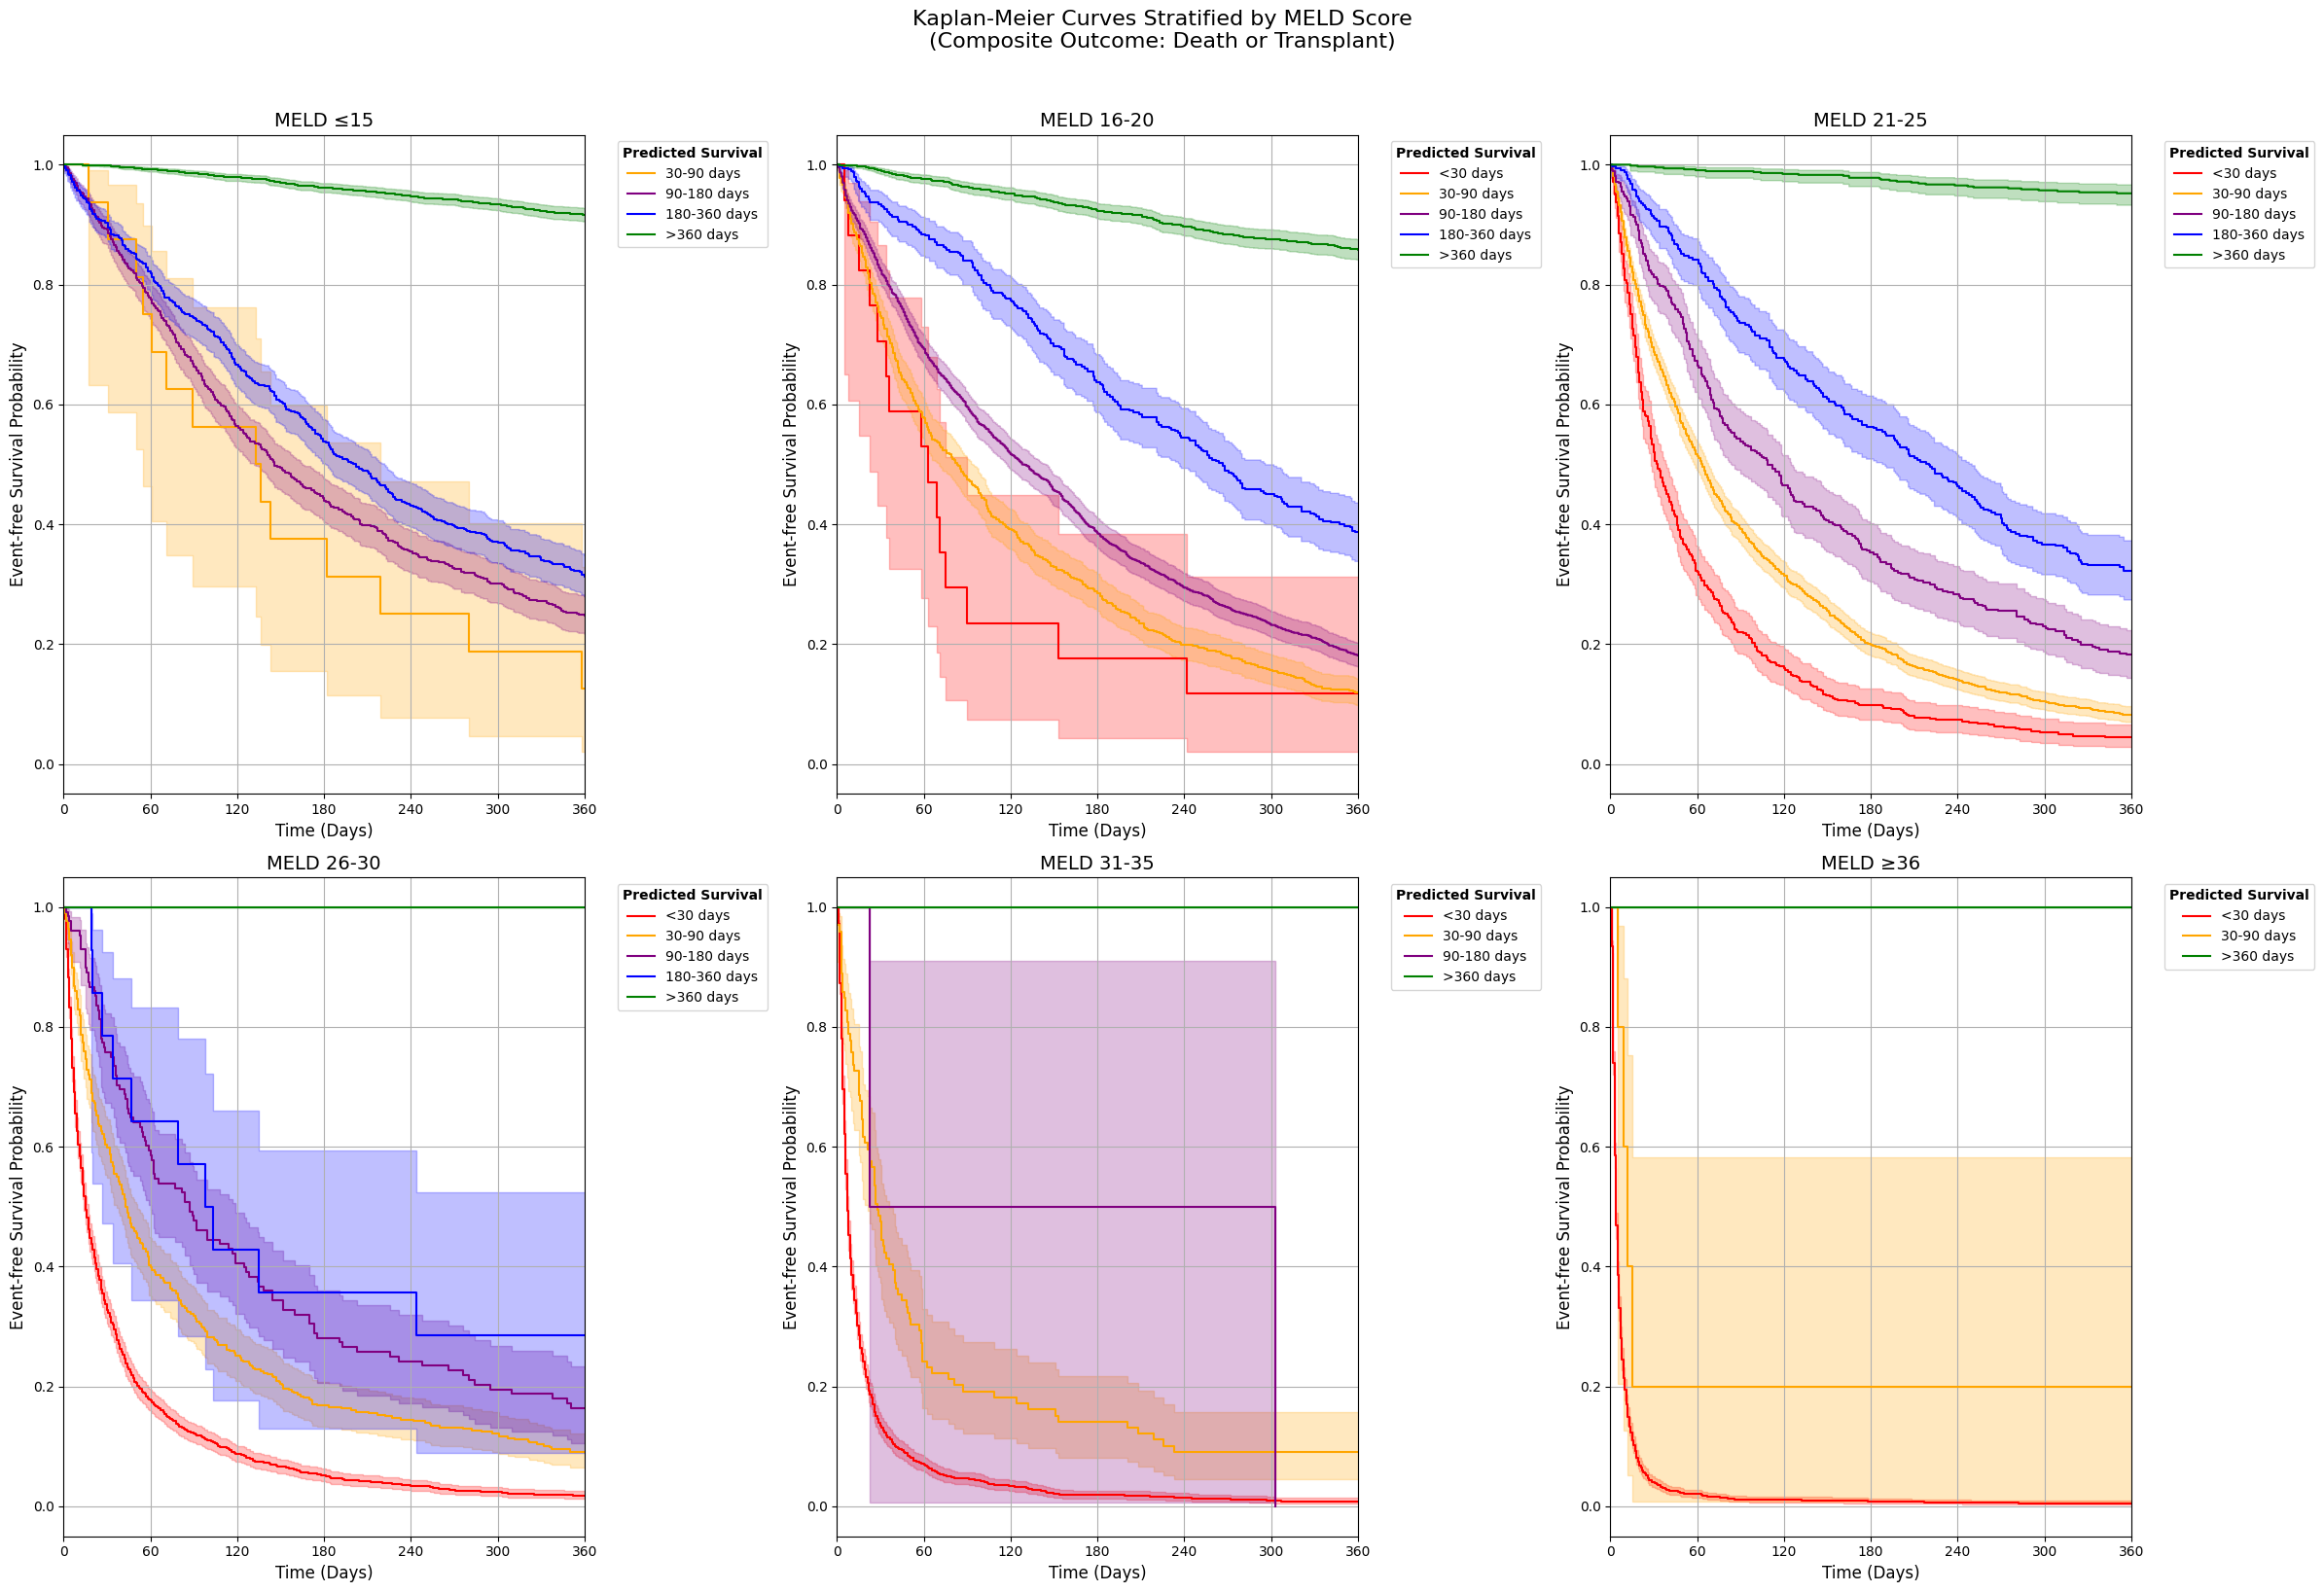


Detailed Statistics by MELD Category and Predicted Survival Group:
------------------------------------------------------------------------------------------------------------------------
MELD Category   Predicted Survival N        Deaths   Transplants  Combined   Median Survival   % Events
------------------------------------------------------------------------------------------------------------------------
≤15             30-90 days      16       0        16           16                   133.0     100.0%
≤15             90-180 days     719      0        719          719                  146.0     100.0%
≤15             180-360 days    700      8        692          700                  201.0     100.0%
≤15             >360 days       2533     692      35           727                 3032.0      28.7%
------------------------------------------------------------------------------------------------------------------------
16-20           <30 days        17       0        17         

In [ ]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def get_time_category(time):
    if time < 30:
        return '<30 days'
    elif time < 90:
        return '30-90 days'
    elif time < 180:
        return '90-180 days'
    elif time < 360:
        return '180-360 days'
    else:
        return '>360 days'

def get_meld_category(meld):
    if meld <= 15:
        return '≤15'
    elif meld <= 20:
        return '16-20'
    elif meld <= 25:
        return '21-25'
    elif meld <= 30:
        return '26-30'
    elif meld <= 35:
        return '31-35'
    else:
        return '≥36'

# Create copy of real_df
analysis_df = real_df.copy()

# Add time categories and MELD categories
analysis_df['time_category'] = analysis_df['median_time_to_event_metric'].apply(get_time_category)
analysis_df['meld_category'] = analysis_df['meld3'].apply(get_meld_category)

# Create composite event indicator (1 for death or transplant, 0 for censoring)
analysis_df['composite_event'] = analysis_df['outcome_encoded'].isin([0, 2]).astype(int)

# Define colors for consistent plotting
colors = {
    '<30 days': 'red',
    '30-90 days': 'orange',
    '90-180 days': 'purple',
    '180-360 days': 'blue',
    '>360 days': 'green'
}

# Create subplots (2x3 grid)
fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.ravel()

# Initialize KM fitter
kmf = KaplanMeierFitter()

# Create plots for each MELD category
meld_categories = ['≤15', '16-20', '21-25', '26-30', '31-35', '≥36']
time_categories = ['<30 days', '30-90 days', '90-180 days', '180-360 days', '>360 days']

for idx, meld_cat in enumerate(meld_categories):
    ax = axes[idx]

    # Get data for this MELD category
    meld_data = analysis_df[analysis_df['meld_category'] == meld_cat]

    # Plot each time category within this MELD category
    for time_cat in time_categories:
        mask = meld_data['time_category'] == time_cat
        if mask.sum() > 0:
            group_df = meld_data[mask]
            kmf.fit(
                group_df['time_to_event'],
                group_df['composite_event'],
                label=f"{time_cat}"
            )
            kmf.plot(ci_show=True, color=colors[time_cat], ax=ax)

    # Customize subplot
    ax.set_xlabel('Time (Days)', fontsize=12)
    ax.set_ylabel('Event-free Survival Probability', fontsize=12)
    ax.set_title(f'MELD {meld_cat}', fontsize=14)
    ax.grid(True)
    ax.set_xlim(0, 360)
    ax.set_xticks(np.arange(0, 361, 60))

    # Add legend with title
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Predicted Survival')
    legend.get_title().set_fontweight('bold')

# Add overall title
fig.suptitle('Kaplan-Meier Curves Stratified by MELD Score\n(Composite Outcome: Death or Transplant)',
             fontsize=16, y=1.02)

# Adjust layout
plt.tight_layout()

# Save as PNG with 300 DPI
plt.savefig('kaplan_meier_composite_stratified.png', dpi=300, bbox_inches='tight', format='png')

# Save as TIFF with 300 DPI
plt.savefig('kaplan_meier_composite_stratified.tiff', dpi=300, bbox_inches='tight', format='tiff')

# Show the plot
plt.show()

# Close the figure to free memory
plt.close()

# Print statistics for each stratum
print("\nDetailed Statistics by MELD Category and Predicted Survival Group:")
print("-" * 120)
print(f"{'MELD Category':<15} {'Predicted Survival':<15} {'N':<8} {'Deaths':<8} {'Transplants':<12} {'Combined':<10} {'Median Survival':>15} {'% Events':>10}")
print("-" * 120)

for meld_cat in meld_categories:
    meld_data = analysis_df[analysis_df['meld_category'] == meld_cat]

    for time_cat in time_categories:
        mask = meld_data['time_category'] == time_cat
        if mask.sum() > 0:
            group_df = meld_data[mask]
            kmf.fit(group_df['time_to_event'], group_df['composite_event'])
            n_total = len(group_df)
            n_deaths = sum(group_df['outcome_encoded'] == 0)
            n_transplants = sum(group_df['outcome_encoded'] == 2)
            n_events = n_deaths + n_transplants
            median = kmf.median_survival_time_
            median_str = f"{median:.1f}" if median is not None else ">360"
            event_pct = (n_events / n_total) * 100

            print(f"{meld_cat:<15} {time_cat:<15} {n_total:<8} {n_deaths:<8} {n_transplants:<12} {n_events:<10} {median_str:>15} {event_pct:>9.1f}%")
    print("-" * 120)

In [ ]:
# Get the specific group of patients
high_meld_long_survival = analysis_df[
    (analysis_df['meld_category'] == '≥36') &
    (analysis_df['time_category'] == '>360 days')
]

# Display key characteristics
print(f"\nNumber of patients: {len(high_meld_long_survival)}")
print("\nKey characteristics:")
print(high_meld_long_survival[['meld3', 'time_to_event',
                              'outcome_encoded', 'INIT_SERUM_SODIUM',
                              'INIT_SERUM_CREAT', 'INIT_INR',
                              'INIT_BILIRUBIN', 'INIT_ALBUMIN',
                              'INIT_DIALYSIS_PRIOR_WEEK', 'GENDER']].head())

# Show distribution of MELD scores
print("\nMELD score distribution:")
print(high_meld_long_survival['meld3'].value_counts().sort_index())

# Show outcome distribution
print("\nOutcome distribution:")
print(high_meld_long_survival['outcome_encoded'].value_counts())

# Print summary statistics
print("\nSummary statistics:")
print(high_meld_long_survival[['meld3', 'time_to_event',
                              'INIT_SERUM_SODIUM', 'INIT_SERUM_CREAT',
                              'INIT_INR', 'INIT_BILIRUBIN',
                              'INIT_ALBUMIN']].describe())


Number of patients: 139

Key characteristics:
     meld3  time_to_event  outcome_encoded  INIT_SERUM_SODIUM  \
109     41          804.0                1              133.0   
198     48         1431.0                1              135.0   
267     40          868.0                1              134.0   
287     40         1061.0                1              138.0   
326     42         2602.0                1              138.0   

     INIT_SERUM_CREAT  INIT_INR  INIT_BILIRUBIN  INIT_ALBUMIN  \
109              1.16       2.2            29.2           2.6   
198              3.56       4.6            37.8           2.5   
267              1.14       3.2             6.5           4.4   
287              1.07       2.1            26.9           2.5   
326              3.68       1.9            49.5           3.5   

    INIT_DIALYSIS_PRIOR_WEEK GENDER  
109                        Y      M  
198                        N      M  
267                        Y      F  
287                

In [ ]:
from sklearn.metrics import roc_auc_score

time_points = [7, 14, 30, 90, 180, 360]
results = []

df_all = real_df.copy()

for t in time_points:
    # Define at-risk set (patients who haven't died or been transplanted by time t)
    at_risk_mask = (
        (df_all['time_to_event'] >= t) |  # Still under observation
        ((df_all['outcome_encoded'] == 0) & (df_all['time_to_event'] <= t))  # Died by t
    )

    df_at_risk = df_all[at_risk_mask].copy()

    # Event indicator (death by time t)
    event_mask = (
        (df_at_risk['outcome_encoded'] == 0) &
        (df_at_risk['time_to_event'] <= t)
    )
    event_indicator = event_mask.astype(int)

    # Risk scores
    risk_metric = -df_at_risk['median_time_to_event_metric']
    risk_meld3 = df_at_risk['meld3']

    # AUC calculation
    if event_indicator.sum() > 0 and event_indicator.sum() < len(event_indicator):
        auc_metric = roc_auc_score(event_indicator, risk_metric)
        auc_meld3 = roc_auc_score(event_indicator, risk_meld3)
    else:
        auc_metric = None
        auc_meld3 = None

    # Count CUMULATIVE transplants up to time t in the FULL dataset
    n_transplants = sum(
        (df_all['outcome_encoded'] == 2) &
        (df_all['time_to_event'] <= t)
    )

    # Count those still in observation (not died, not transplanted by time t)
    n_still_waiting = sum(
        (df_all['time_to_event'] > t) &
        (df_all['outcome_encoded'] != 0)  # Not died
    )

    results.append({
        'Time': t,
        'N_at_risk': len(df_at_risk),
        'N_events_by_t': event_indicator.sum(),
        'N_transplants_by_t': n_transplants,
        'N_still_waiting': n_still_waiting,
        'AUC_metric': auc_metric,
        'AUC_meld3': auc_meld3
    })

results_df = pd.DataFrame(results)
print("\nTime-Dependent AUC (Including Transplants as Censored):")
print(results_df)


Time-Dependent AUC (Including Transplants as Censored):
   Time  N_at_risk  N_events_by_t  N_transplants_by_t  N_still_waiting  \
0     7      15615            222                3011            12384   
1    14      14226            360                4220            11165   
2    30      12768            601                5581             9780   
3    90      10514            961                7713             7564   
4   180       8966           1285                9137             6025   
5   360       7671           1732               10245             4737   

   AUC_metric  AUC_meld3  
0    0.830944   0.933784  
1    0.857370   0.936563  
2    0.852576   0.922712  
3    0.828583   0.871386  
4    0.829984   0.823955  
5    0.860176   0.775822  


In [ ]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data
        max_time: Optional maximum follow-up time to consider

    Returns:
        DataFrame prepared for survival analysis
    """
    # Create a copy of the input data
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome_encoded'] == 0).astype(int)

    # If max_time is specified, adjust the data
    if max_time is not None:
        # For those who survived past max_time, censor at max_time
        mask = analysis_df['time_to_event'] > max_time
        analysis_df.loc[mask, 'time_to_event'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis
hazard_results = []

for t in time_points:
    # Prepare survival data
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using median_time_to_event_metric only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['time_to_event', 'death_event', 'median_time_to_event_metric']].copy()
    cph_metric.fit(data_metric, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['time_to_event', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3
    })

results_df = pd.DataFrame(hazard_results)
print("\nComparison of Concordance Indices:")
print(results_df)


Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3
0     7        0.778771       0.910144
1    14        0.788439       0.907405
2    30        0.778734       0.893942
3    90        0.743091       0.850515
4   180        0.727744       0.815401
5   360        0.726653       0.783077


In [ ]:
def prepare_survival_data(df, max_time=None):
    """
    Prepare survival data for Cox analysis.

    Args:
        df: DataFrame containing the data
        max_time: Optional maximum follow-up time to consider

    Returns:
        DataFrame prepared for survival analysis
    """
    # Create a copy of the input data
    analysis_df = df.copy()

    # Create death_event column (1 for death, 0 for censoring/transplant)
    analysis_df['death_event'] = (analysis_df['outcome_encoded'] == 0).astype(int)

    # If max_time is specified, adjust the data
    if max_time is not None:
        # For those who survived past max_time, censor at max_time
        mask = analysis_df['time_to_event'] > max_time
        analysis_df.loc[mask, 'time_to_event'] = max_time
        analysis_df.loc[mask, 'death_event'] = 0

    return analysis_df

# Now run the concordance analysis
hazard_results = []

for t in time_points:
    # Prepare survival data
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # --- Model 1: Using median_time_to_event_metric only ---
    cph_metric = CoxPHFitter()
    data_metric = analysis_df[['time_to_event', 'death_event', 'median_time_to_event_metric']].copy()
    cph_metric.fit(data_metric, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_metric = cph_metric.concordance_index_

    # --- Model 2: Using meld3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['time_to_event', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 3: Combined model using both predictors ---
    cph_combined = CoxPHFitter()
    data_combined = analysis_df[['time_to_event', 'death_event',
                                'median_time_to_event_metric', 'meld3']].copy()
    cph_combined.fit(data_combined, duration_col='time_to_event',
                    event_col='death_event', show_progress=False)
    c_index_combined = cph_combined.concordance_index_

    # Extract coefficients and p-values from summary
    summary = cph_combined.summary

    hazard_results.append({
        'Time': t,
        'c_index_metric': c_index_metric,
        'c_index_meld3': c_index_meld3,
        'c_index_combined': c_index_combined,
        'hr_metric': np.exp(summary.loc['median_time_to_event_metric', 'coef']),
        'hr_meld3': np.exp(summary.loc['meld3', 'coef']),
        'p_metric': summary.loc['median_time_to_event_metric', 'p'],
        'p_meld3': summary.loc['meld3', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Print results in a formatted way
print("\nComparison of Concordance Indices:")
print(results_df[['Time', 'c_index_metric', 'c_index_meld3', 'c_index_combined']].round(3))
print("\nHazard Ratios and P-values from Combined Model:")
print(results_df[['Time', 'hr_metric', 'hr_meld3', 'p_metric', 'p_meld3']].round(3))


Comparison of Concordance Indices:
   Time  c_index_metric  c_index_meld3  c_index_combined
0     7           0.779          0.910             0.913
1    14           0.788          0.907             0.912
2    30           0.779          0.894             0.900
3    90           0.743          0.851             0.864
4   180           0.728          0.815             0.841
5   360           0.727          0.783             0.826

Hazard Ratios and P-values from Combined Model:
   Time  hr_metric  hr_meld3  p_metric  p_meld3
0     7      0.998     1.182       0.0      0.0
1    14      0.998     1.194       0.0      0.0
2    30      0.998     1.193       0.0      0.0
3    90      0.998     1.165       0.0      0.0
4   180      0.998     1.138       0.0      0.0
5   360      0.998     1.111       0.0      0.0


In [ ]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd

def prepare_competing_risk_data(df, max_time=None):
    """
    Prepare data for competing risks analysis

    Args:
        df: DataFrame containing the data
        max_time: Optional maximum follow-up time to consider

    Returns:
        Two DataFrames: one for death analysis, one for transplant analysis
    """
    analysis_df = df.copy()

    # For death analysis (event=0)
    death_df = analysis_df.copy()
    death_df['event'] = (analysis_df['outcome_encoded'] == 0).astype(int)

    # For transplant analysis (event=2)
    transplant_df = analysis_df.copy()
    transplant_df['event'] = (analysis_df['outcome_encoded'] == 2).astype(int)

    # Apply max_time if specified
    if max_time is not None:
        for df in [death_df, transplant_df]:
            mask = df['time_to_event'] > max_time
            df.loc[mask, 'time_to_event'] = max_time
            df.loc[mask, 'event'] = 0

    return death_df, transplant_df

def calculate_competing_risk_cindices(death_df, transplant_df):
    """
    Calculate c-indices for competing risks models
    Returns c-indices for both death and transplant predictions
    """
    results = {}

    # For death prediction
    for name, data in [
        ('metric_death', death_df[['time_to_event', 'event', 'median_time_to_event_metric']]),
        ('meld3_death', death_df[['time_to_event', 'event', 'meld3']]),
        ('combined_death', death_df[['time_to_event', 'event', 'median_time_to_event_metric', 'meld3']])
    ]:
        cph = CoxPHFitter()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        results[name] = cph.concordance_index_

    # For transplant prediction
    for name, data in [
        ('metric_tx', transplant_df[['time_to_event', 'event', 'median_time_to_event_metric']]),
        ('meld3_tx', transplant_df[['time_to_event', 'event', 'meld3']]),
        ('combined_tx', transplant_df[['time_to_event', 'event', 'median_time_to_event_metric', 'meld3']])
    ]:
        cph = CoxPHFitter()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        results[name] = cph.concordance_index_

    return results

# Run analysis for each time point
competing_risk_results = []

for t in time_points:
    print(f"\nAnalyzing time point: {t}")

    # Prepare data
    death_df, transplant_df = prepare_competing_risk_data(real_df, max_time=t)

    # Calculate c-indices
    indices = calculate_competing_risk_cindices(death_df, transplant_df)

    # Add number of events
    n_deaths = death_df['event'].sum()
    n_transplants = transplant_df['event'].sum()

    # Store results
    result = {
        'Time': t,
        'n_deaths': n_deaths,
        'n_transplants': n_transplants
    }
    result.update(indices)
    competing_risk_results.append(result)

# Convert to DataFrame and display results
results_df = pd.DataFrame(competing_risk_results)

# Print formatted results
print("\nDeath Prediction C-indices:")
print(results_df[['Time', 'n_deaths', 'metric_death', 'meld3_death', 'combined_death']].round(3))
print("\nTransplant Prediction C-indices:")
print(results_df[['Time', 'n_transplants', 'metric_tx', 'meld3_tx', 'combined_tx']].round(3))


Analyzing time point: 7


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(



Analyzing time point: 14


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(



Analyzing time point: 30

Analyzing time point: 90

Analyzing time point: 180

Analyzing time point: 360

Death Prediction C-indices:
   Time  n_deaths  metric_death  meld3_death  combined_death
0     7       222         0.779        0.910           0.913
1    14       360         0.788        0.907           0.912
2    30       601         0.779        0.894           0.900
3    90       961         0.743        0.851           0.864
4   180      1285         0.728        0.815           0.841
5   360      1732         0.727        0.783           0.826

Transplant Prediction C-indices:
   Time  n_transplants  metric_tx  meld3_tx  combined_tx
0     7           3011      0.885     0.854        0.884
1    14           4220      0.883     0.844        0.881
2    30           5581      0.878     0.826        0.875
3    90           7713      0.871     0.794        0.867
4   180           9137      0.869     0.775        0.865
5   360          10245      0.870     0.763        0.866


In [ ]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd
from tqdm.notebook import tqdm

def prepare_data(df, t=90):
    """
    Prepare data for 90-day death analysis
    """
    analysis_df = df.copy()

    # Create death event indicator (1 for death, 0 for censoring/transplant)
    analysis_df['event'] = (analysis_df['outcome_encoded'] == 0).astype(int)

    # Apply 90-day cutoff
    mask = analysis_df['time_to_event'] > t
    analysis_df.loc[mask, 'time_to_event'] = t
    analysis_df.loc[mask, 'event'] = 0

    return analysis_df

def get_model_predictions(df, model_type='meld3'):
    """Get predictions from fitted Cox model"""
    if model_type == 'meld3':
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -df['meld3']  # Negative because higher MELD3 means higher risk
    else:  # combined
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'median_time_to_event_metric', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -(df['median_time_to_event_metric'] * cph.params_['median_time_to_event_metric'] +
                df['meld3'] * cph.params_['meld3'])

def bootstrap_comparison(df, n_bootstrap=500):
    """Perform bootstrap comparison of MELD3 vs combined model"""
    n_samples = len(df)
    diffs = np.zeros(n_bootstrap)

    # Get baseline concordance indices
    print("\nCalculating baseline concordance indices...")
    meld3_pred = get_model_predictions(df, 'meld3')
    combined_pred = get_model_predictions(df, 'combined')

    baseline_meld3 = concordance_index(
        df['time_to_event'],
        meld3_pred,
        df['event']
    )
    baseline_combined = concordance_index(
        df['time_to_event'],
        combined_pred,
        df['event']
    )

    print("\nRunning bootstrap iterations...")
    for i in tqdm(range(n_bootstrap), desc='Bootstrap Progress'):
        # Generate bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_df = df.iloc[indices].copy()

        # Get predictions for bootstrap sample
        meld3_pred = get_model_predictions(boot_df, 'meld3')
        combined_pred = get_model_predictions(boot_df, 'combined')

        # Calculate c-indices
        meld3_cindex = concordance_index(
            boot_df['time_to_event'],
            meld3_pred,
            boot_df['event']
        )
        combined_cindex = concordance_index(
            boot_df['time_to_event'],
            combined_pred,
            boot_df['event']
        )

        diffs[i] = combined_cindex - meld3_cindex

    return {
        'baseline': (baseline_meld3, baseline_combined),
        'diffs': diffs
    }

# Prepare data
print("Preparing data...")
analysis_df = prepare_data(real_df, t=90)

# Print event counts
print("\nCounts at 90 days:")
print(f"Deaths: {sum(analysis_df['event'] == 1)}")
print(f"Censored (includes transplants and alive): {sum(analysis_df['event'] == 0)}")
print(f"Total: {len(analysis_df)}")

# Run bootstrap
results = bootstrap_comparison(analysis_df)

# Print results
print("\nBaseline C-indices:")
print(f"MELD3: {results['baseline'][0]:.3f}")
print(f"Combined: {results['baseline'][1]:.3f}")
print(f"Observed difference: {results['baseline'][1] - results['baseline'][0]:.3f}")

# Calculate confidence intervals and p-values
ci = np.percentile(results['diffs'], [2.5, 97.5])
p_value = 2 * min(np.mean(results['diffs'] <= 0),
                  np.mean(results['diffs'] >= 0))

print("\nBootstrap Results:")
print(f"Mean difference in c-index: {np.mean(results['diffs']):.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")
print(f"P-value: {p_value:.4f}")

# Create histogram of differences
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(results['diffs'], bins=50, density=True, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label='Null hypothesis (no difference)')
plt.axvline(x=np.mean(results['diffs']), color='g', linestyle='-',
            label=f'Mean difference: {np.mean(results["diffs"]):.3f}')
plt.xlabel('Difference in C-index (Combined - MELD3)')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Difference in C-indices')
plt.legend()
plt.savefig('bootstrap_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

Preparing data...

Counts at 90 days:
Deaths: 961
Censored (includes transplants and alive): 17367
Total: 18328

Calculating baseline concordance indices...

Running bootstrap iterations...


Bootstrap Progress:   0%|          | 0/500 [00:00<?, ?it/s]


Baseline C-indices:
MELD3: 0.851
Combined: 0.864
Observed difference: 0.014

Bootstrap Results:
Mean difference in c-index: 0.014
95% CI: [0.012, 0.017]
P-value: 0.0000


In [ ]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd
from tqdm.notebook import tqdm

def get_meld_stratum(meld_score):
    """Assign MELD score to appropriate stratum"""
    if meld_score <= 15:
        return '≤15'
    elif meld_score <= 20:
        return '16-20'
    elif meld_score <= 25:
        return '21-25'
    elif meld_score <= 30:
        return '26-30'
    elif meld_score <= 35:
        return '31-35'
    else:
        return '≥36'

def get_model_predictions(df, model_type='meld3'):
    """Get predictions from fitted Cox model"""
    if model_type == 'meld3':
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -df['meld3']  # Negative because higher MELD3 means higher risk
    else:  # combined
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'median_time_to_event_metric', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -(df['median_time_to_event_metric'] * cph.params_['median_time_to_event_metric'] +
                df['meld3'] * cph.params_['meld3'])

def prepare_stratified_data(df, t=90):
    """Prepare data with MELD strata"""
    analysis_df = df.copy()

    # Create death event indicator
    analysis_df['event'] = (analysis_df['outcome_encoded'] == 0).astype(int)

    # Apply 90-day cutoff
    mask = analysis_df['time_to_event'] > t
    analysis_df.loc[mask, 'time_to_event'] = t
    analysis_df.loc[mask, 'event'] = 0

    # Add MELD stratum
    analysis_df['meld_stratum'] = analysis_df['meld3'].apply(get_meld_stratum)

    return analysis_df

def bootstrap_comparison_by_stratum(df, stratum, n_bootstrap=500):
    """Perform bootstrap comparison for a specific MELD stratum"""
    stratum_df = df[df['meld_stratum'] == stratum].copy()
    n_samples = len(stratum_df)

    if n_samples < 10:  # Skip if too few samples
        return None

    diffs = np.zeros(n_bootstrap)
    meld3_cindices = np.zeros(n_bootstrap)
    combined_cindices = np.zeros(n_bootstrap)

    # Get baseline concordance indices
    meld3_pred = get_model_predictions(stratum_df, 'meld3')
    combined_pred = get_model_predictions(stratum_df, 'combined')

    baseline_meld3 = concordance_index(
        stratum_df['time_to_event'],
        meld3_pred,
        stratum_df['event']
    )
    baseline_combined = concordance_index(
        stratum_df['time_to_event'],
        combined_pred,
        stratum_df['event']
    )

    # Run bootstrap
    for i in range(n_bootstrap):
        # Generate bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_df = stratum_df.iloc[indices].copy()

        # Get predictions
        meld3_pred = get_model_predictions(boot_df, 'meld3')
        combined_pred = get_model_predictions(boot_df, 'combined')

        # Calculate c-indices
        meld3_cindex = concordance_index(
            boot_df['time_to_event'],
            meld3_pred,
            boot_df['event']
        )
        combined_cindex = concordance_index(
            boot_df['time_to_event'],
            combined_pred,
            boot_df['event']
        )

        meld3_cindices[i] = meld3_cindex
        combined_cindices[i] = combined_cindex
        diffs[i] = combined_cindex - meld3_cindex

    return {
        'stratum': stratum,
        'n_patients': n_samples,
        'n_deaths': sum(stratum_df['event']),
        'baseline_meld3': baseline_meld3,
        'baseline_combined': baseline_combined,
        'observed_diff': baseline_combined - baseline_meld3,
        'meld3_mean': np.mean(meld3_cindices),
        'combined_mean': np.mean(combined_cindices),
        'improvement_mean': np.mean(diffs),
        'ci_lower': np.percentile(diffs, 2.5),
        'ci_upper': np.percentile(diffs, 97.5),
        'p_value': 2 * min(np.mean(diffs <= 0), np.mean(diffs >= 0))
    }

# Prepare data
print("Preparing data...")
analysis_df = prepare_stratified_data(real_df, t=90)

# Print overall counts
print("\nOverall Counts at 90 days:")
print(f"Deaths: {sum(analysis_df['event'] == 1)}")
print(f"Censored (includes transplants and alive): {sum(analysis_df['event'] == 0)}")
print(f"Total: {len(analysis_df)}")

# Print stratum sizes before analysis
print("\nSample sizes by stratum:")
stratum_counts = analysis_df.groupby('meld_stratum').agg({
    'event': ['count', 'sum']
}).round(3)
stratum_counts.columns = ['Total', 'Deaths']
print(stratum_counts)

# Analyze each stratum
results = []
strata = ['≤15', '16-20', '21-25', '26-30', '31-35', '≥36']

print("\nAnalyzing by MELD strata...")
for stratum in tqdm(strata, desc='Analyzing strata'):
    stratum_results = bootstrap_comparison_by_stratum(analysis_df, stratum)
    if stratum_results is not None:
        results.append(stratum_results)

# Convert to DataFrame and display results
results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.3f}'.format)

print("\nResults by MELD Stratum:")
print("\nBaseline Performance:")
display_df = pd.DataFrame({
    'Stratum': results_df['stratum'],
    'N': results_df['n_patients'],
    'Deaths': results_df['n_deaths'],
    'MELD3 C-index': results_df['baseline_meld3'],
    'Combined C-index': results_df['baseline_combined'],
    'Improvement': results_df['observed_diff']
})
print(display_df.to_string(index=False))

print("\nBootstrap Analysis of Improvement:")
display_df = pd.DataFrame({
    'Stratum': results_df['stratum'],
    'Mean Improvement': results_df['improvement_mean'],
    '95% CI Lower': results_df['ci_lower'],
    '95% CI Upper': results_df['ci_upper'],
    'P-value': results_df['p_value']
})
print(display_df.to_string(index=False))

# Create visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Plot point estimates and CIs
y_pos = np.arange(len(results))
plt.errorbar(
    [r['improvement_mean'] for r in results],
    y_pos,
    xerr=[(np.array([r['improvement_mean'] for r in results]) -
           np.array([r['ci_lower'] for r in results])),
          (np.array([r['ci_upper'] for r in results]) -
           np.array([r['improvement_mean'] for r in results]))],
    fmt='o',
    capsize=5
)

# Add reference line at 0
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)

# Customize plot
plt.yticks(y_pos, [r['stratum'] for r in results])
plt.xlabel('Improvement in C-index (Combined - MELD3)')
plt.ylabel('MELD Stratum')
plt.title('Improvement in C-index by MELD Stratum\nwith 95% Confidence Intervals')

# Add annotations for sample sizes
for i, r in enumerate(results):
    plt.text(max([r['ci_upper'] for r in results]) + 0.01,
             i,
             f"n={r['n_patients']} ({r['n_deaths']} deaths)",
             va='center')

plt.tight_layout()
plt.savefig('improvement_by_stratum.png', dpi=300, bbox_inches='tight')
plt.close()

Preparing data...

Overall Counts at 90 days:
Deaths: 961
Censored (includes transplants and alive): 17367
Total: 18328

Sample sizes by stratum:
              Total  Deaths
meld_stratum               
16-20          4404     103
21-25          3536     175
26-30          2486     175
31-35          1766     175
≤15            3968      33
≥36            2168     300

Analyzing by MELD strata...


Analyzing strata:   0%|          | 0/6 [00:00<?, ?it/s]


Results by MELD Stratum:

Baseline Performance:
Stratum    N  Deaths  MELD3 C-index  Combined C-index  Improvement
    ≤15 3968      33          0.626             0.669        0.043
  16-20 4404     103          0.542             0.535       -0.007
  21-25 3536     175          0.598             0.627        0.029
  26-30 2486     175          0.578             0.602        0.024
  31-35 1766     175          0.575             0.586        0.011
    ≥36 2168     300          0.592             0.640        0.048

Bootstrap Analysis of Improvement:
Stratum  Mean Improvement  95% CI Lower  95% CI Upper  P-value
    ≤15             0.047         0.023         0.074    0.004
  16-20            -0.011        -0.088         0.044    0.956
  21-25             0.023         0.001         0.036    0.044
  26-30             0.021        -0.011         0.038    0.112
  31-35             0.010        -0.007         0.029    0.276
    ≥36             0.048         0.034         0.064    0.000


In [ ]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd
from tqdm.notebook import tqdm

def prepare_data(df, t=90):
    """
    Prepare data for 90-day death analysis
    """
    analysis_df = df.copy()

    # Create death event indicator (1 for death, 0 for censoring/transplant)
    analysis_df['event'] = (analysis_df['outcome_encoded'] == 0).astype(int)

    # Apply 90-day cutoff
    mask = analysis_df['time_to_event'] > t
    analysis_df.loc[mask, 'time_to_event'] = t
    analysis_df.loc[mask, 'event'] = 0

    # Convert predicted survival to weeks
    analysis_df['survival_weeks'] = np.ceil(analysis_df['median_time_to_event_metric'] / 7).astype(int)

    return analysis_df

def get_model_predictions(df, model_type='meld3'):
    """Get predictions from fitted Cox model"""
    if model_type == 'meld3':
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -df['meld3']  # Negative because higher MELD3 means higher risk
    else:  # combined
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'survival_weeks', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -(df['survival_weeks'] * cph.params_['survival_weeks'] +
                df['meld3'] * cph.params_['meld3'])

def bootstrap_comparison(df, n_bootstrap=500):
    """Perform bootstrap comparison of MELD3 vs combined model"""
    n_samples = len(df)
    diffs = np.zeros(n_bootstrap)

    # Get baseline concordance indices
    print("\nCalculating baseline concordance indices...")
    meld3_pred = get_model_predictions(df, 'meld3')
    combined_pred = get_model_predictions(df, 'combined')

    baseline_meld3 = concordance_index(
        df['time_to_event'],
        meld3_pred,
        df['event']
    )
    baseline_combined = concordance_index(
        df['time_to_event'],
        combined_pred,
        df['event']
    )

    print("\nRunning bootstrap iterations...")
    for i in tqdm(range(n_bootstrap), desc='Bootstrap Progress'):
        # Generate bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_df = df.iloc[indices].copy()

        # Get predictions for bootstrap sample
        meld3_pred = get_model_predictions(boot_df, 'meld3')
        combined_pred = get_model_predictions(boot_df, 'combined')

        # Calculate c-indices
        meld3_cindex = concordance_index(
            boot_df['time_to_event'],
            meld3_pred,
            boot_df['event']
        )
        combined_cindex = concordance_index(
            boot_df['time_to_event'],
            combined_pred,
            boot_df['event']
        )

        diffs[i] = combined_cindex - meld3_cindex

    return {
        'baseline': (baseline_meld3, baseline_combined),
        'diffs': diffs
    }

# Prepare data
print("Preparing data...")
analysis_df = prepare_data(real_df, t=90)

# Print event counts
print("\nCounts at 90 days:")
print(f"Deaths: {sum(analysis_df['event'] == 1)}")
print(f"Censored (includes transplants and alive): {sum(analysis_df['event'] == 0)}")
print(f"Total: {len(analysis_df)}")

# Run bootstrap
results = bootstrap_comparison(analysis_df)

# Print results
print("\nBaseline C-indices:")
print(f"MELD3: {results['baseline'][0]:.3f}")
print(f"Combined: {results['baseline'][1]:.3f}")
print(f"Observed difference: {results['baseline'][1] - results['baseline'][0]:.3f}")

# Calculate confidence intervals and p-values
ci = np.percentile(results['diffs'], [2.5, 97.5])
p_value = 2 * min(np.mean(results['diffs'] <= 0),
                  np.mean(results['diffs'] >= 0))

print("\nBootstrap Results:")
print(f"Mean difference in c-index: {np.mean(results['diffs']):.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")
print(f"P-value: {p_value:.4f}")

# Create histogram of differences
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(results['diffs'], bins=50, density=True, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label='Null hypothesis (no difference)')
plt.axvline(x=np.mean(results['diffs']), color='g', linestyle='-',
            label=f'Mean difference: {np.mean(results["diffs"]):.3f}')
plt.xlabel('Difference in C-index (Combined - MELD3)')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Difference in C-indices')
plt.legend()
plt.savefig('bootstrap_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

Preparing data...

Counts at 90 days:
Deaths: 961
Censored (includes transplants and alive): 17367
Total: 18328

Calculating baseline concordance indices...

Running bootstrap iterations...


Bootstrap Progress:   0%|          | 0/500 [00:00<?, ?it/s]


Baseline C-indices:
MELD3: 0.851
Combined: 0.864
Observed difference: 0.014

Bootstrap Results:
Mean difference in c-index: 0.014
95% CI: [0.012, 0.016]
P-value: 0.0000


In [ ]:
import numpy as np
import pandas as pd
from itertools import combinations

def prepare_data(df, t=90):
    """
    Prepare data for analysis
    """
    # Create copy and calculate everything at once
    analysis_df = df.copy()
    analysis_df['event'] = (analysis_df['outcome_encoded'] == 0).astype(int)
    analysis_df['survival_weeks'] = np.ceil(analysis_df['median_time_to_event_metric'] / 7).astype(int)
    analysis_df.loc[analysis_df['time_to_event'] > t, ['time_to_event', 'event']] = [t, 0]

    return analysis_df

def analyze_tiebreaker_accuracy(df):
    """
    Analyze accuracy of weekly survival categories as tiebreaker
    for patients with equal MELD scores - optimized version
    """
    results = []

    # Get counts of each MELD score
    meld_counts = df['meld3'].value_counts()
    meld_scores_with_ties = meld_counts[meld_counts > 1].index

    for meld_score in meld_scores_with_ties:
        same_meld = df[df['meld3'] == meld_score].copy()
        n_patients = len(same_meld)

        # Get indices of patients who died
        died_indices = same_meld[same_meld['event'] == 1].index

        # Skip if no deaths
        if len(died_indices) == 0:
            continue

        concordant = 0
        discordant = 0
        total_pairs = 0

        # Only look at combinations where at least one patient died
        for idx1, idx2 in combinations(same_meld.index, 2):
            pt1 = same_meld.loc[idx1]
            pt2 = same_meld.loc[idx2]

            # Skip if neither died
            if not (pt1['event'] or pt2['event']):
                continue

            # Skip transplant cases
            if ((pt1['outcome_encoded'] == 2 and pt1['time_to_event'] < pt2['time_to_event']) or
                (pt2['outcome_encoded'] == 2 and pt2['time_to_event'] < pt1['time_to_event'])):
                continue

            total_pairs += 1

            # Compare predictions
            pred_pt1_dies_first = pt1['survival_weeks'] < pt2['survival_weeks']

            # Compare outcomes
            if pt1['event'] and pt2['event']:
                actually_died_first = pt1['time_to_event'] < pt2['time_to_event']
            else:
                actually_died_first = pt1['event']

            if pred_pt1_dies_first == actually_died_first:
                concordant += 1
            else:
                discordant += 1

        if total_pairs > 0:
            results.append({
                'meld_score': meld_score,
                'n_patients': n_patients,
                'n_comparable_pairs': total_pairs,
                'n_concordant': concordant,
                'n_discordant': discordant,
                'accuracy': concordant / total_pairs
            })

    return pd.DataFrame(results)

# Prepare the data
print("Preparing data...")
analysis_df = prepare_data(real_df, t=90)

# Analyze tiebreaker accuracy
print("Analyzing tiebreaker accuracy...")
results = analyze_tiebreaker_accuracy(analysis_df)

# Calculate overall statistics
total_concordant = results['n_concordant'].sum()
total_discordant = results['n_discordant'].sum()
total_pairs = total_concordant + total_discordant
overall_accuracy = total_concordant / total_pairs if total_pairs > 0 else np.nan

# Print results
print("\nOverall Tiebreaker Performance:")
print(f"Total comparable pairs: {total_pairs}")
print(f"Concordant pairs: {total_concordant}")
print(f"Discordant pairs: {total_discordant}")
print(f"Overall accuracy: {overall_accuracy:.3f}")

# Print detailed results for MELD scores with most patients
print("\nDetailed Results for Top 10 MELD Scores (by number of patients):")
results_sorted = results.sort_values('n_patients', ascending=False)
print(results_sorted.head(10).round(3))

# Quick summary of prediction differences
print("\nSummary of Weekly Prediction Differences for Equal MELD Scores:")
meld_summary = analysis_df.groupby('meld3').agg({
    'survival_weeks': ['count', 'min', 'max']
}).reset_index()
meld_summary.columns = ['meld_score', 'n_patients', 'min_weeks', 'max_weeks']
meld_summary = meld_summary[meld_summary['n_patients'] > 1]
meld_summary['week_range'] = meld_summary['max_weeks'] - meld_summary['min_weeks']

print(meld_summary.sort_values('n_patients', ascending=False).head(10).round(3))

Preparing data...
Analyzing tiebreaker accuracy...

Overall Tiebreaker Performance:
Total comparable pairs: 276688
Concordant pairs: 101953
Discordant pairs: 174735
Overall accuracy: 0.368

Detailed Results for Top 10 MELD Scores (by number of patients):
   meld_score  n_patients  n_comparable_pairs  n_concordant  n_discordant  \
0          19         926               19340          7843         11497   
1          20         919               18311          7570         10741   
2          18         896               13588          6179          7409   
3          21         850               21847          8968         12879   
4          16         847               12617          5674          6943   
5          17         816               12856          5713          7143   
6          15         741                5156          2436          2720   
7          22         733               15345          5572          9773   
8          23         726               13316       

In [ ]:
def create_sequential_score(df):
    """
    Create a sequential score where:
    1. Primary sorting is by MELD3
    2. For equal MELD3 scores, use predicted survival as tiebreaker
    """
    df = df.copy()

    # Create groups of patients with same MELD3 score
    for meld_score in df['meld3'].unique():
        mask = df['meld3'] == meld_score
        if mask.sum() > 1:  # Only need tiebreaker if multiple patients have same MELD
            # Within same MELD score, use negative of predicted survival as tiebreaker
            # (negative because lower survival = higher priority)
            df.loc[mask, 'tiebreaker'] = -df.loc[mask, 'median_time_to_event_metric']
        else:
            df.loc[mask, 'tiebreaker'] = 0

    # Combine: MELD3 as primary score, standardized tiebreaker as secondary
    # Multiply tiebreaker by small number to make it secondary to MELD3
    df['sequential_risk'] = df['meld3'] + (0.01 * df['tiebreaker'])

    return df['sequential_risk']

# Run the analysis
hazard_results = []

for t in time_points:
    # Prepare survival data
    analysis_df = prepare_survival_data(real_df, max_time=t)

    # Add sequential risk score
    analysis_df['sequential_risk'] = create_sequential_score(analysis_df)

    # --- Model 1: Using MELD3 only ---
    cph_meld3 = CoxPHFitter()
    data_meld3 = analysis_df[['time_to_event', 'death_event', 'meld3']].copy()
    cph_meld3.fit(data_meld3, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_meld3 = cph_meld3.concordance_index_

    # --- Model 2: Using sequential approach ---
    cph_sequential = CoxPHFitter()
    data_sequential = analysis_df[['time_to_event', 'death_event', 'sequential_risk']].copy()
    cph_sequential.fit(data_sequential, duration_col='time_to_event', event_col='death_event', show_progress=False)
    c_index_sequential = cph_sequential.concordance_index_

    # Store results
    hazard_results.append({
        'Time': t,
        'c_index_meld3': c_index_meld3,
        'c_index_sequential': c_index_sequential,
        'hr_meld3': np.exp(cph_meld3.summary.loc['meld3', 'coef']),
        'hr_sequential': np.exp(cph_sequential.summary.loc['sequential_risk', 'coef']),
        'p_meld3': cph_meld3.summary.loc['meld3', 'p'],
        'p_sequential': cph_sequential.summary.loc['sequential_risk', 'p']
    })

results_df = pd.DataFrame(hazard_results)

# Add analysis of how often tiebreaker changes ordering
same_meld_analysis = []
for meld_score in analysis_df['meld3'].unique():
    mask = analysis_df['meld3'] == meld_score
    n_patients = mask.sum()
    if n_patients > 1:
        same_meld_analysis.append({
            'MELD3': meld_score,
            'N_Patients': n_patients,
            'N_Different_Predictions': len(analysis_df[mask]['median_time_to_event_metric'].unique())
        })

# Print results
print("\nComparison of MELD3 vs Sequential Approach:")
print("\nConcordance Indices:")
print(results_df[['Time', 'c_index_meld3', 'c_index_sequential']].round(3))

print("\nHazard Ratios and P-values:")
print(results_df[['Time', 'hr_meld3', 'hr_sequential', 'p_meld3', 'p_sequential']].round(3))

print("\nAnalysis of Tiebreaker Impact:")
same_meld_df = pd.DataFrame(same_meld_analysis)
print(same_meld_df.sort_values('N_Patients', ascending=False).head(10))


Comparison of MELD3 vs Sequential Approach:

Concordance Indices:
   Time  c_index_meld3  c_index_sequential
0     7          0.910               0.913
1    14          0.907               0.912
2    30          0.894               0.901
3    90          0.851               0.865
4   180          0.815               0.841
5   360          0.783               0.824

Hazard Ratios and P-values:
   Time  hr_meld3  hr_sequential  p_meld3  p_sequential
0     7     1.193          1.184      0.0           0.0
1    14     1.199          1.193      0.0           0.0
2    30     1.189          1.189      0.0           0.0
3    90     1.157          1.162      0.0           0.0
4   180     1.133          1.139      0.0           0.0
5   360     1.109          1.120      0.0           0.0

Analysis of Tiebreaker Impact:
    MELD3  N_Patients  N_Different_Predictions
16     19         926                      909
14     20         919                      893
8      18         896                 

In [ ]:
import numpy as np
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import pandas as pd
from tqdm.notebook import tqdm

def create_sequential_score(df):
    """
    Create a sequential score where:
    1. Primary sorting is by MELD3
    2. For equal MELD3 scores, use predicted survival as tiebreaker
    """
    df = df.copy()

    # Create groups of patients with same MELD3 score
    for meld_score in df['meld3'].unique():
        mask = df['meld3'] == meld_score
        if mask.sum() > 1:  # Only need tiebreaker if multiple patients have same MELD
            # Within same MELD score, use negative of predicted survival as tiebreaker
            df.loc[mask, 'tiebreaker'] = -df.loc[mask, 'median_time_to_event_metric']
        else:
            df.loc[mask, 'tiebreaker'] = 0

    # Combine: MELD3 as primary score, standardized tiebreaker as secondary
    df['sequential_risk'] = df['meld3'] + (0.01 * df['tiebreaker'])

    return df['sequential_risk']

def prepare_data(df, t=90):
    """
    Prepare data for 90-day death analysis
    """
    analysis_df = df.copy()

    # Create death event indicator (1 for death, 0 for censoring/transplant)
    analysis_df['event'] = (analysis_df['outcome_encoded'] == 0).astype(int)

    # Add sequential risk score
    analysis_df['sequential_risk'] = create_sequential_score(analysis_df)

    # Apply 90-day cutoff
    mask = analysis_df['time_to_event'] > t
    analysis_df.loc[mask, 'time_to_event'] = t
    analysis_df.loc[mask, 'event'] = 0

    return analysis_df

def get_model_predictions(df, model_type='meld3'):
    """Get predictions from fitted Cox model"""
    if model_type == 'meld3':
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'meld3']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -df['meld3']  # Negative because higher MELD3 means higher risk
    else:  # sequential
        cph = CoxPHFitter()
        data = df[['time_to_event', 'event', 'sequential_risk']].copy()
        cph.fit(data, duration_col='time_to_event', event_col='event', show_progress=False)
        return -df['sequential_risk']  # Negative because higher risk score means higher risk

def bootstrap_comparison(df, n_bootstrap=500):
    """Perform bootstrap comparison of MELD3 vs sequential model"""
    n_samples = len(df)
    diffs = np.zeros(n_bootstrap)

    # Get baseline concordance indices
    print("\nCalculating baseline concordance indices...")
    meld3_pred = get_model_predictions(df, 'meld3')
    sequential_pred = get_model_predictions(df, 'sequential')

    baseline_meld3 = concordance_index(
        df['time_to_event'],
        meld3_pred,
        df['event']
    )
    baseline_sequential = concordance_index(
        df['time_to_event'],
        sequential_pred,
        df['event']
    )

    print("\nRunning bootstrap iterations...")
    for i in tqdm(range(n_bootstrap), desc='Bootstrap Progress'):
        # Generate bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_df = df.iloc[indices].copy()

        # Get predictions for bootstrap sample
        meld3_pred = get_model_predictions(boot_df, 'meld3')
        sequential_pred = get_model_predictions(boot_df, 'sequential')

        # Calculate c-indices
        meld3_cindex = concordance_index(
            boot_df['time_to_event'],
            meld3_pred,
            boot_df['event']
        )
        sequential_cindex = concordance_index(
            boot_df['time_to_event'],
            sequential_pred,
            boot_df['event']
        )

        diffs[i] = sequential_cindex - meld3_cindex

    return {
        'baseline': (baseline_meld3, baseline_sequential),
        'diffs': diffs
    }

# Prepare data
print("Preparing data...")
analysis_df = prepare_data(real_df, t=90)

# Print event counts
print("\nCounts at 90 days:")
print(f"Deaths: {sum(analysis_df['event'] == 1)}")
print(f"Censored (includes transplants and alive): {sum(analysis_df['event'] == 0)}")
print(f"Total: {len(analysis_df)}")

# Additional analysis of tiebreaker impact
same_meld_analysis = []
for meld_score in analysis_df['meld3'].unique():
    mask = analysis_df['meld3'] == meld_score
    n_patients = mask.sum()
    if n_patients > 1:
        same_meld_analysis.append({
            'MELD3': meld_score,
            'N_Patients': n_patients,
            'N_Different_Predictions': len(analysis_df[mask]['median_time_to_event_metric'].unique())
        })

print("\nTop 5 MELD scores with most ties:")
same_meld_df = pd.DataFrame(same_meld_analysis)
print(same_meld_df.sort_values('N_Patients', ascending=False).head())

# Run bootstrap
results = bootstrap_comparison(analysis_df)

# Print results
print("\nBaseline C-indices:")
print(f"MELD3: {results['baseline'][0]:.3f}")
print(f"Sequential: {results['baseline'][1]:.3f}")
print(f"Observed difference: {results['baseline'][1] - results['baseline'][0]:.3f}")

# Calculate confidence intervals and p-values
ci = np.percentile(results['diffs'], [2.5, 97.5])
p_value = 2 * min(np.mean(results['diffs'] <= 0),
                  np.mean(results['diffs'] >= 0))

print("\nBootstrap Results:")
print(f"Mean difference in c-index: {np.mean(results['diffs']):.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")
print(f"P-value: {p_value:.4f}")

# Create histogram of differences
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(results['diffs'], bins=50, density=True, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label='Null hypothesis (no difference)')
plt.axvline(x=np.mean(results['diffs']), color='g', linestyle='-',
            label=f'Mean difference: {np.mean(results["diffs"]):.3f}')
plt.xlabel('Difference in C-index (Sequential - MELD3)')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Difference in C-indices')
plt.legend()
plt.savefig('bootstrap_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

Preparing data...

Counts at 90 days:
Deaths: 961
Censored (includes transplants and alive): 17367
Total: 18328

Top 5 MELD scores with most ties:
    MELD3  N_Patients  N_Different_Predictions
16     19         926                      909
14     20         919                      893
8      18         896                      886
2      21         850                      800
19     16         847                      842

Calculating baseline concordance indices...

Running bootstrap iterations...


Bootstrap Progress:   0%|          | 0/500 [00:00<?, ?it/s]


Baseline C-indices:
MELD3: 0.851
Sequential: 0.865
Observed difference: 0.014

Bootstrap Results:
Mean difference in c-index: 0.014
95% CI: [0.012, 0.017]
P-value: 0.0000
